In [1]:
%load_ext autoreload
%autoreload 2

- pre-data means...
- post-data means...

- Tasks 1-3
- Settings 1-3
- Different amounts of noise in setting 1, but all at rate 1/n^(0.26) for the nuisance parameter estimators
- Different scaling factors in plots
- Plugin (pi) vs. doubly robust (dr)
- Meaning of pihat, muhat0, phihat

In [ ]:
import joblib
import os
import pickle
import random

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import expit
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


In [ ]:
from counterfactualEO.functions_estimation import(
    risk_coefs,
    fairness_coefs,
    optimize,
)

from counterfactualEO.functions_evaluation import(
    metrics_post_simple,
    metrics_sim_task1_to_df,
    coverage,
)

from counterfactualEO.functions_simulation import (
    add_noise_expit,
    add_noise_logit,
    generate_data_pre,
    generate_data_post,
    generate_data_post_noisy,
    check_data_post,
    simulate_true,
    simulate_task1,
    simulate_task2,
    simulate_performance_tradeoff,
    add_reference_values,
)

from counterfactualEO.functions_plotting import (
    transform_metrics,
    plot_noise,
    plot_metrics,
)

In [4]:
%matplotlib inline

sns.set_style("ticks")

# Make sure tick marks are visible
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['ytick.left'] = True

# Ensure ticks are outward and visible
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'

# Add gridlines explicitly for both axes
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.axis'] = 'both'   # <--- Enable both x and y gridlines
plt.rcParams['axes.grid.which'] = 'major'
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['grid.color'] = '0.9'
mpl.rcParams['grid.alpha'] = 1.0

In [5]:
# Paths to save data and figures

OUTPATH = '../outputs'
FIGPATH = '../figures'

# Testing data generating parameters

In [ ]:
prob_A = 0.3
beta_X = [1, -0.8, 4, 2]
beta_D_pre = [0.2, -1, 1, -1, 1]
beta_D_post = [0.2, -1, 1, -1, 1, 1]
beta_Y0 = [-5, 2, -3, 4, -5]
beta_Y1 = [1, -2, 3, -4, 5]

A = 'A'
X = ['X1', 'X2', 'X3', 'X4']
R = 'R'
D = 'D'
Y = 'Y'

R_preds = [A] + [XX for XX in X]
nuis_preds = [A] + [XX for XX in X] + [R]

In [16]:
## Data used to train input predictor R
dat_pre = generate_data_pre(10_000,prob_A, beta_X, beta_D_pre, beta_Y0, beta_Y1,
                            trunc_pi=0.975)
R_learner = RandomForestClassifier()
R_learner.fit(dat_pre[R_preds], dat_pre['Y'])

## Data used to train fair derived predictor
data = generate_data_post(100_000, prob_A, beta_X, beta_D_post, beta_Y0, beta_Y1,
                          R_learner, trunc_pi=0.975)

## Check data distribution
- Make sure both groups have propensities near 0 for the decision `D`
- Relatedly, make sure the treatment `D = 0` occurs frequently enough
- Make sure cross-tabs of binary values don't have empty cells
- Generally make sure the data generating process doesn't look pathological somehow

Cross-tabs for sensitive feature A, decision D, potential outcome Y0, and observable outcome Y.
---------------
D      0.0    1.0
A                
0.0  27395  42343
1.0  26543   3719
---------------
Y0     0.0    1.0
A                
0.0  35003  34735
1.0   7131  23131
---------------
Y      0.0    1.0
A                
0.0  18791  50947
1.0   7192  23070
---------------

How often Y = Y0: 0.59283 

Properties of input predictor R

-------------------------
Confusion matrix for Y, R
-------------------------
[[0.09929 0.16054]
 [0.11158 0.62859]] 

------------------------------
Classification report for Y, R
------------------------------
              precision    recall  f1-score   support

       Y = 0       0.47      0.38      0.42     25983
       Y = 1       0.80      0.85      0.82     74017

    accuracy                           0.73    100000
   macro avg       0.63      0.62      0.62    100000
weighted avg       0.71      0.73      0.72    100000
 

---------------------

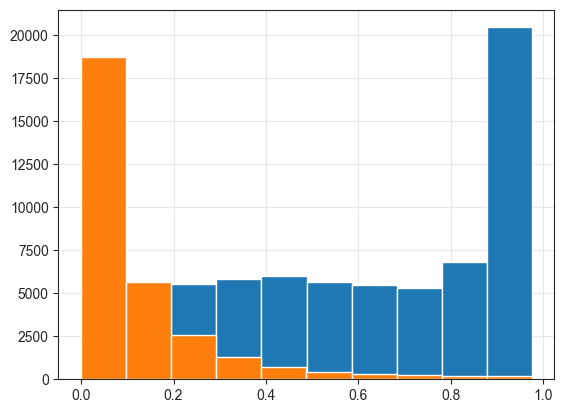

In [17]:
check_data_post(data)

## Check noise added to nuisance parameters

Noise needs to be the right size to meaningfully illustrate convergence. We'll check how noise affects the parameters of the linear program.

We'll compare adding noise directly to $\pi(X)$ and $\mu_0(X)$, on their original scale where they lie in (0, 1), to adding noise on the logit scale and taking the expit to transform them back. The advantage of the latter is that on the logit scale they're unbounded, and when we take the expit to transform them back they still lie in (0, 1). If we add noise on their original scale (referred to as the "expit" scale just for contrast), then we have to clip the values to restore the range to (0, 1).

In [51]:
# Parameters for post-intervention data generation
data_params = {
    'prob_A': prob_A,
    'beta_X': beta_X,
    'beta_D': beta_D_post,
    'beta_Y0': beta_Y0,
    'beta_Y1': beta_Y1,
    'model_R': R_learner,
    'trunc_pi': 0.975,  # Truncation for propensity scores
}

In [18]:
# Get the true values for the LP optimization parameters
epsilon_pos = 0.10
epsilon_neg = 0.10
obj_true = risk_coefs(data, A='A', R='R', outcome='mu0')
pos_true, neg_true = fairness_coefs(data, A='A', R='R', outcome='mu0')
theta = optimize(obj_true, pos_true, neg_true, epsilon_pos, epsilon_neg)

### Adding noise on expit scale to $\pi(X)$ and $\mu0(X)$

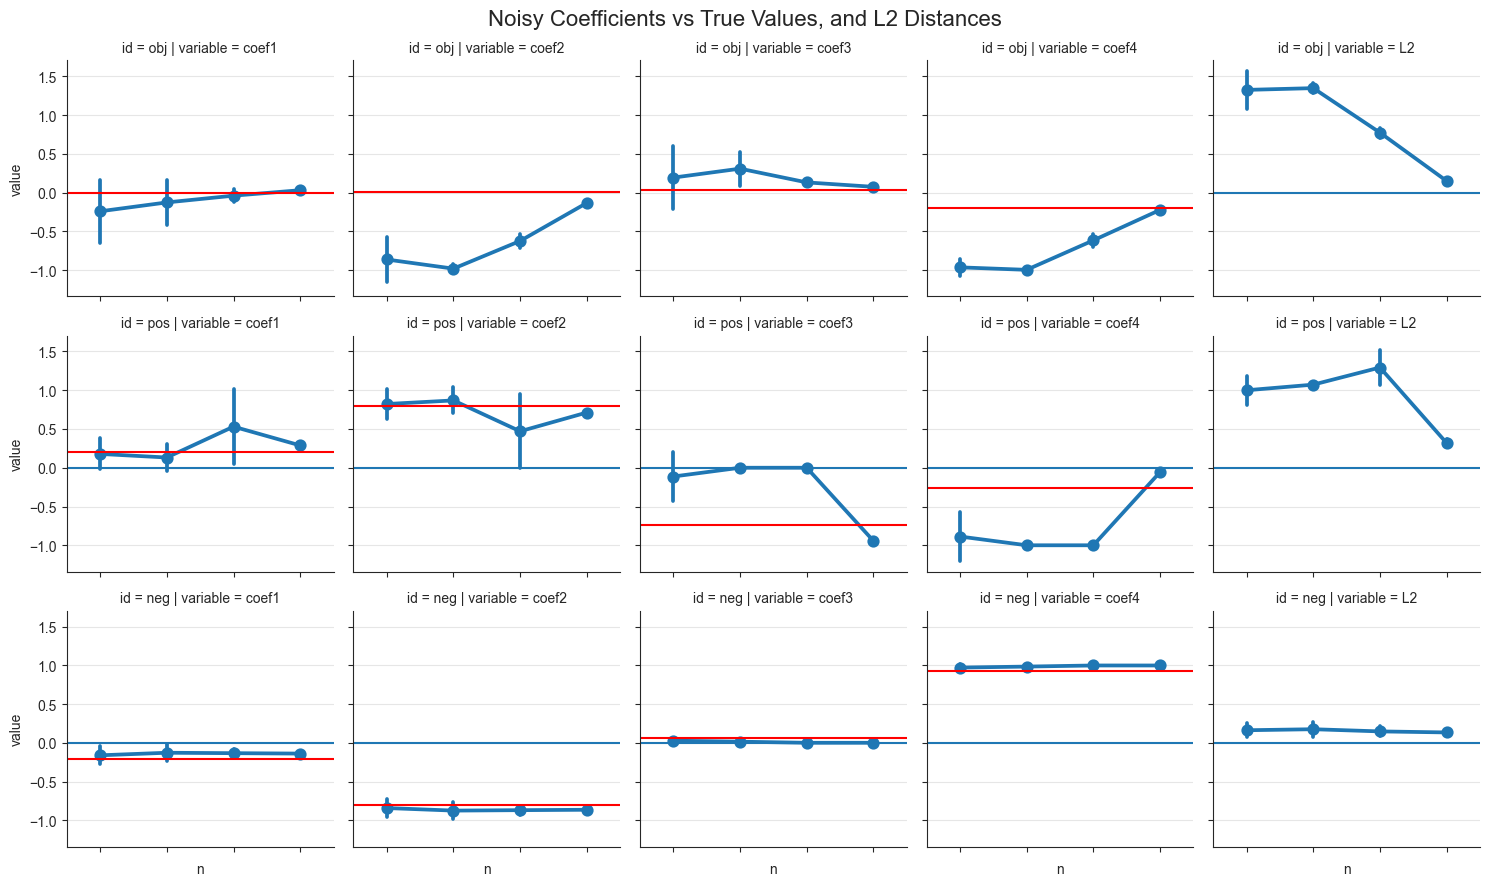

In [45]:
## Setting noise coefficient to 10
n_arr = [200, 1000, 5000, 20000]
mc_reps = 10

noise_coef = 10
res_noise10 = add_noise_expit(n_arr, mc_reps, data_params, obj_true, pos_true, neg_true,
                    noise_coef, trunc_pi=0.975, verbose=False)
plot_noise(res_noise10, obj_true, pos_true, neg_true)

Sample size 200:
Sample size 1000:
Sample size 5000:
Sample size 20000:


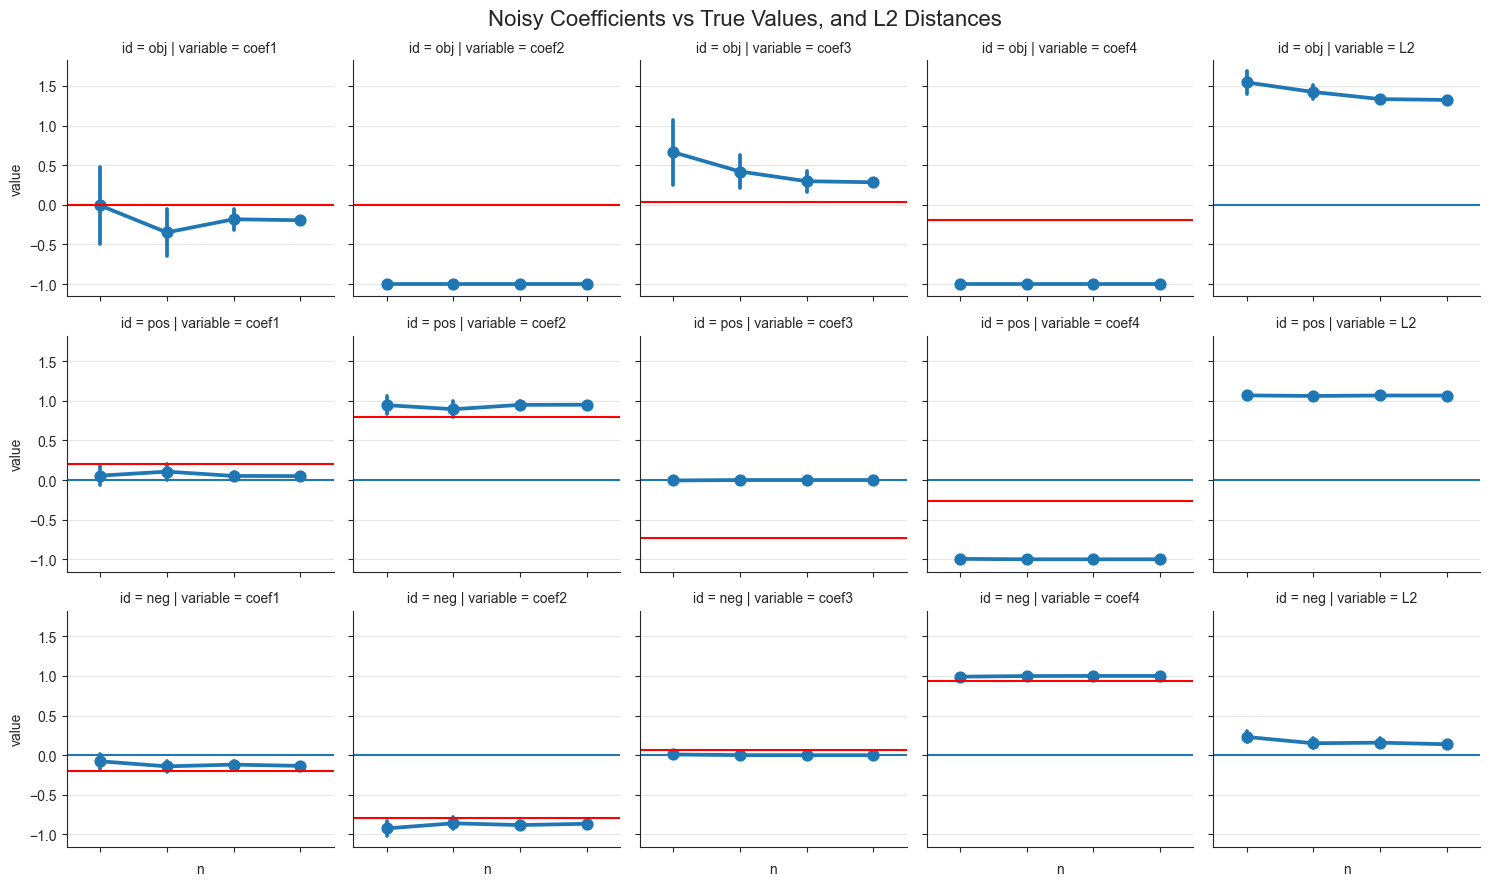

In [43]:
## Setting noise coefficient to 30
noise_coef = 30
res_noise30 = add_noise_expit(n_arr, mc_reps, data_params, obj_true, pos_true, neg_true,
                    noise_coef, trunc_pi=0.975, verbose=False)
plot_noise(res_noise30, obj_true, pos_true, neg_true)

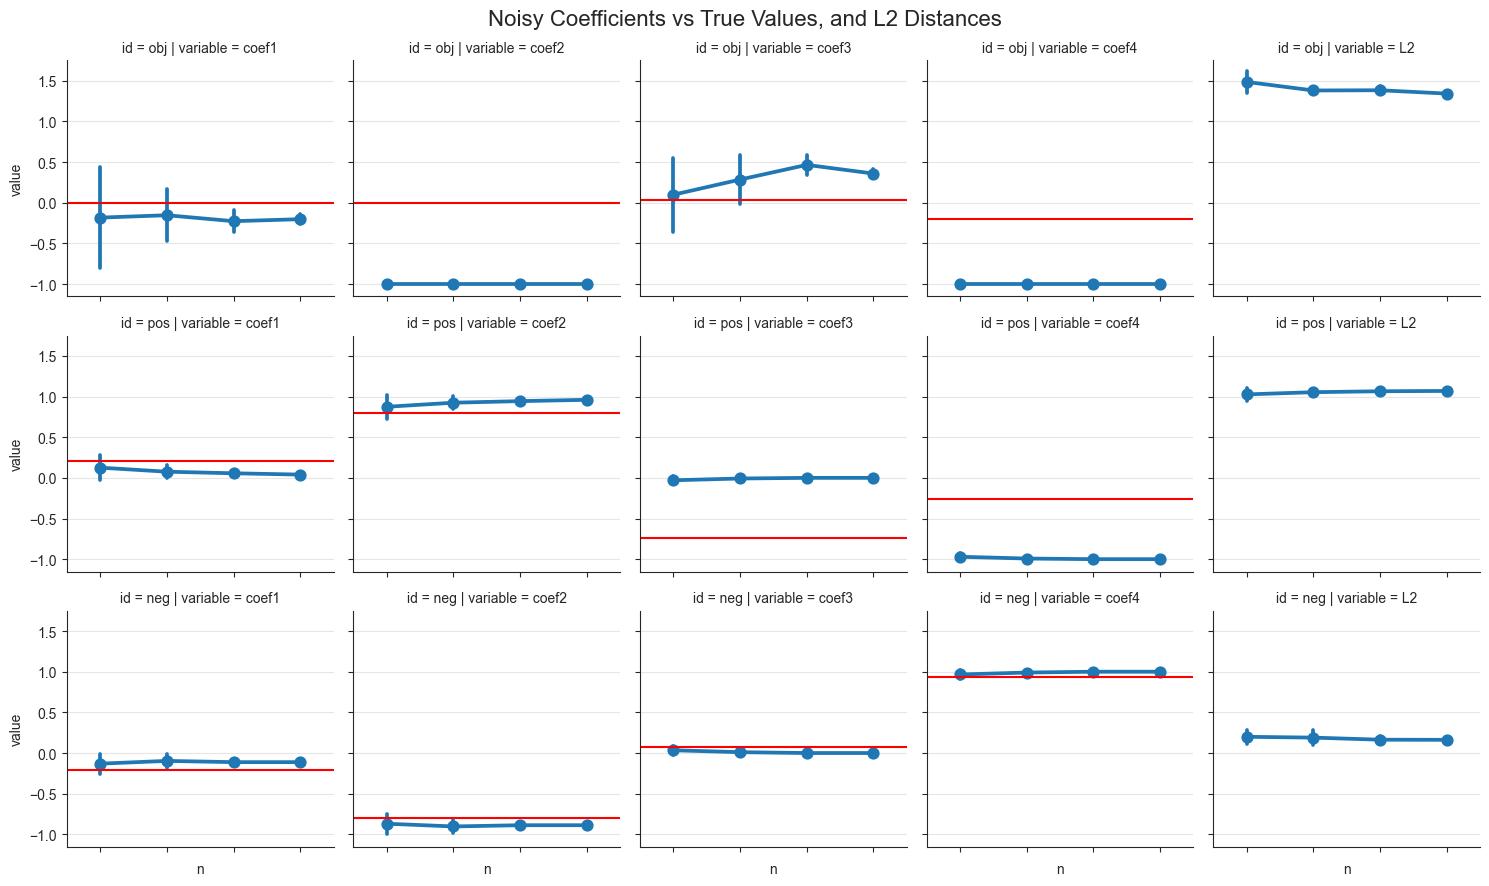

In [49]:
## Setting noise coefficient to 50
## This gives too much noise, with some coefficient vectors landing at the 
## extremes of 1 or -1. 

noise_coef = 50
res_noise50 = add_noise_expit(n_arr, mc_reps, data_params, obj_true, pos_true, neg_true,
                    noise_coef, trunc_pi=0.975, verbose=False)
plot_noise(res_noise50, obj_true, pos_true, neg_true)

### Adding noise on logit scale to $\pi(X)$ and $\mu0(X)$

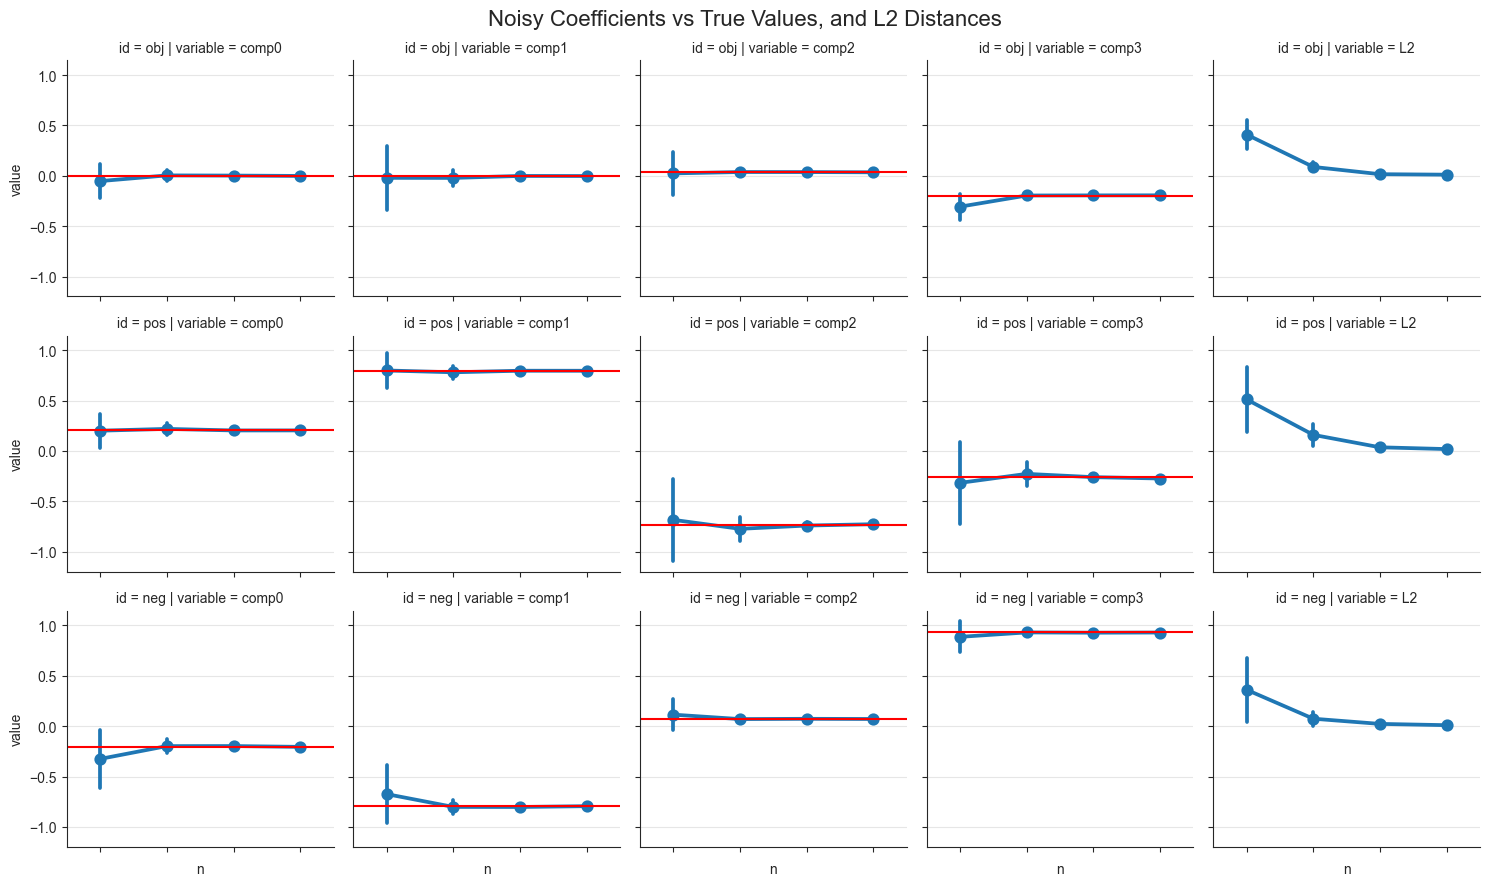

In [50]:
## Noise coefficient of 10
n_arr = [200, 1000, 5000, 20000]
mc_reps = 10

noise_coef = 10
res_noise10_2 = add_noise_logit(n_arr, mc_reps, data_params, obj_true, pos_true,
                                neg_true, noise_coef=noise_coef, verbose=False)
plot_noise(res_noise10_2, obj_true, pos_true, neg_true)

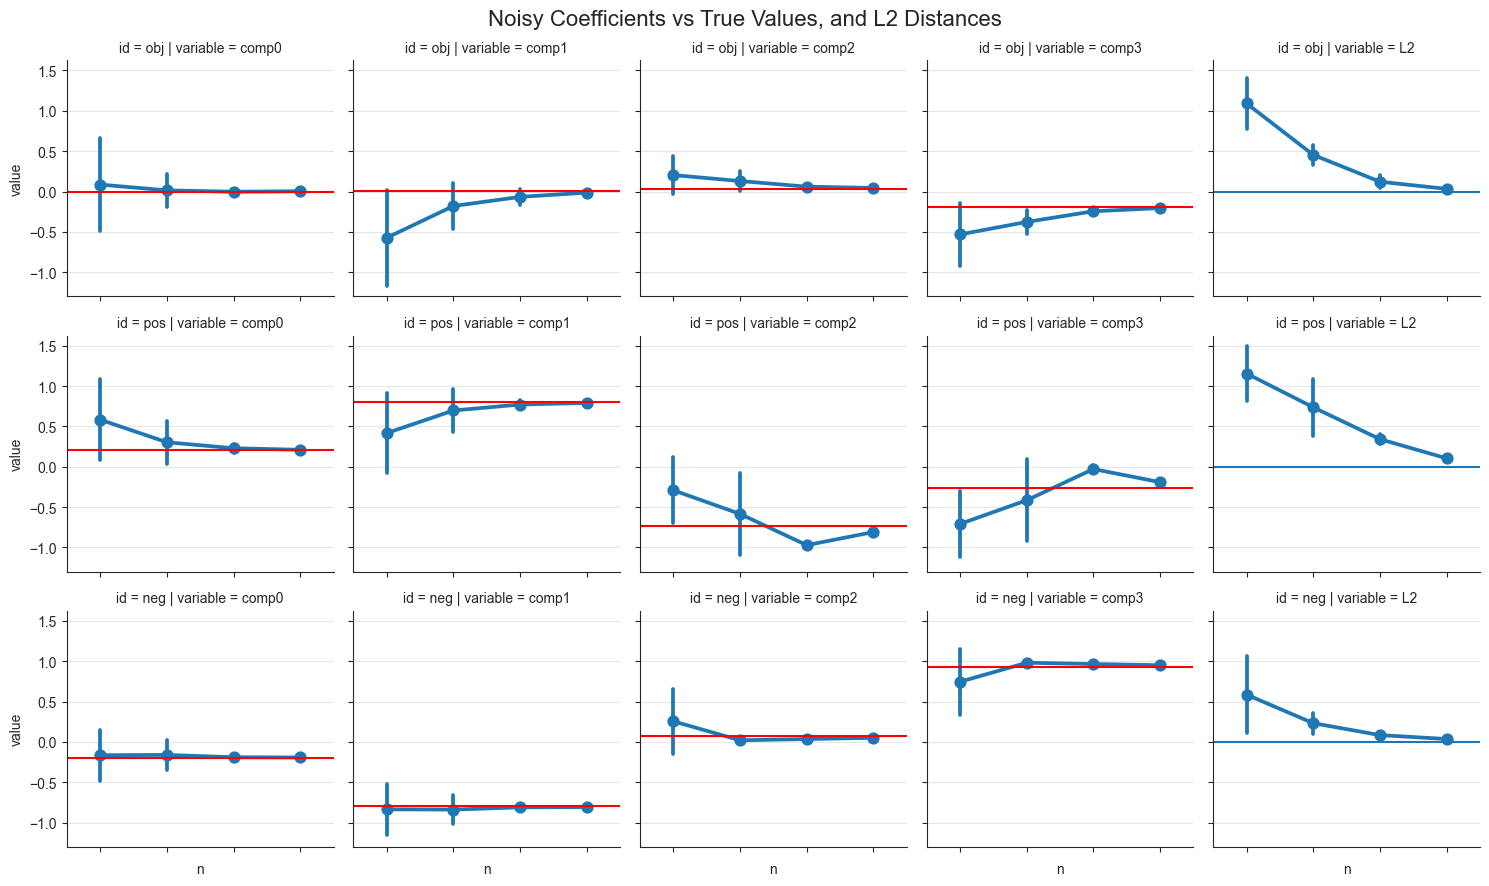

In [53]:
## Noise coefficient of 30
noise_coef = 30
res_noise30_2 = add_noise_logit(n_arr, mc_reps, data_params, obj_true, pos_true,
                                neg_true, noise_coef=noise_coef, verbose=False)
plot_noise(res_noise30_2, obj_true, pos_true, neg_true)

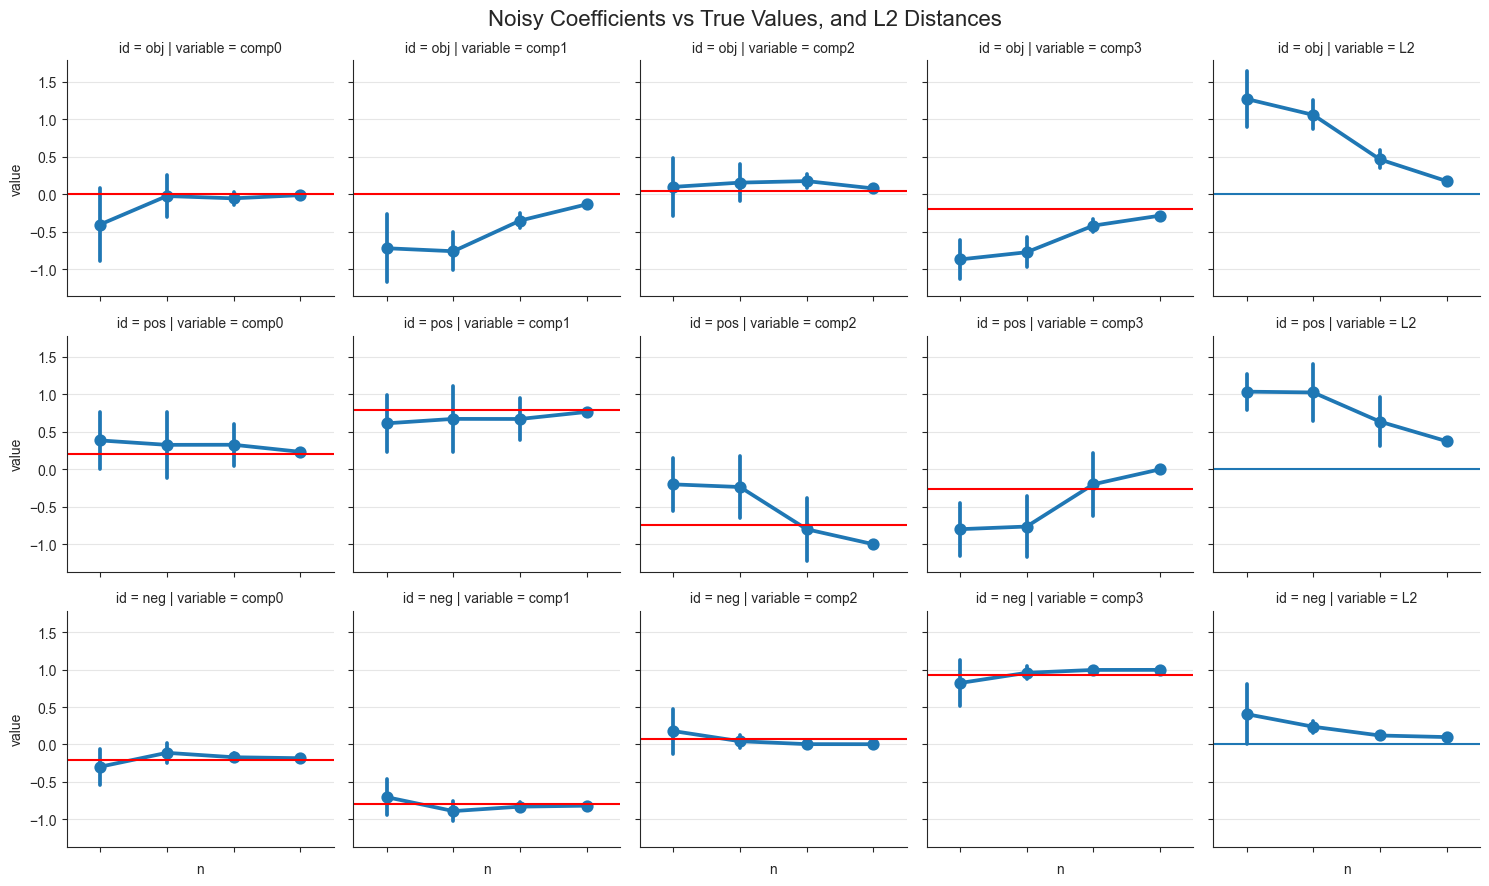

In [54]:
## Noise coefficient of 50
noise_coef = 50
res_noise50_2 = add_noise_logit(n_arr, mc_reps, data_params, obj_true, pos_true,
                                neg_true, noise_coef=noise_coef, verbose=False)
plot_noise(res_noise50_2, obj_true, pos_true, neg_true)

In [57]:
## Checking generate_data_post_noisy
data_test10 = generate_data_post_noisy(10_000, 10, **data_params)
data_test30 = generate_data_post_noisy(10_000, 30, **data_params)

In [59]:
print(pearsonr(data_test10['pi'], data_test10['pihat']))
print(pearsonr(data_test30['pi'], data_test30['pihat']))
print(pearsonr(data_test10['mu0'], data_test10['muhat0']))
print(pearsonr(data_test30['mu0'], data_test30['muhat0']))

PearsonRResult(statistic=0.9297094261690265, pvalue=0.0)
PearsonRResult(statistic=0.6353248376637383, pvalue=0.0)
PearsonRResult(statistic=0.9833949409647313, pvalue=0.0)
PearsonRResult(statistic=0.8819396791187113, pvalue=0.0)


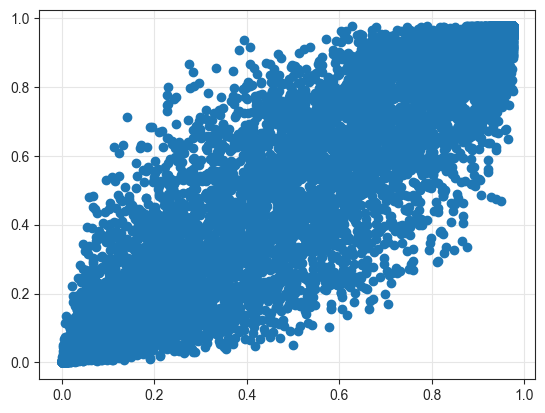

In [60]:
plt.plot(data_test10['pi'], data_test10['pihat'], marker = 'o', linestyle = 'none')

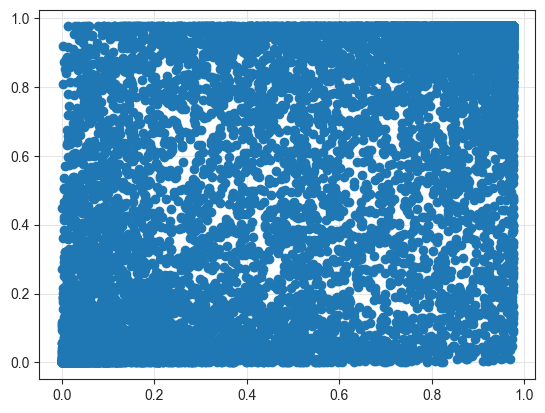

In [61]:
plt.plot(data_test30['pi'], data_test30['pihat'], marker = 'o', linestyle = 'none')

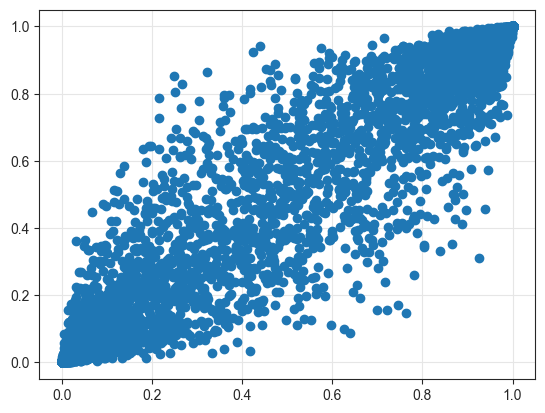

In [62]:
plt.plot(data_test10['mu0'], data_test10['muhat0'], marker = 'o', linestyle = 'none')

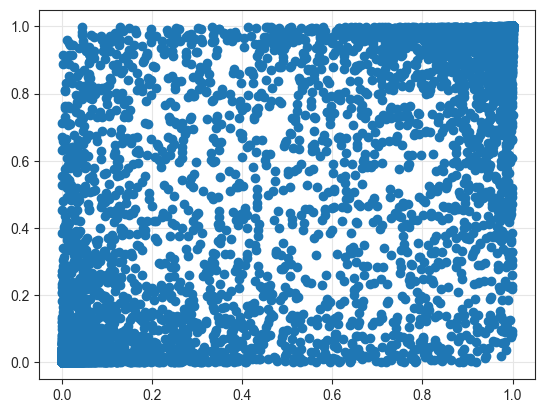

In [63]:
plt.plot(data_test30['mu0'], data_test30['muhat0'], marker = 'o', linestyle = 'none')

# Simulations Setup

## Pre-data generation parameters

In [ ]:
prob_A = 0.3
beta_X = [1, -0.8, 4, 2]
beta_D_pre = [0.2, -1, 1, -1, 1]
beta_D_post = [0.2, -1, 1, -1, 1, 1]
beta_Y0 = [-5, 2, -3, 4, -5]
beta_Y1 = [1, -2, 3, -4, 5]

A = 'A'
X = ['X1', 'X2', 'X3', 'X4']
R = 'R'
D = 'D'
Y = 'Y'

R_preds = [A] + [XX for XX in X]

## Train input predictor R

In [11]:
random.seed(42)

dat_pre = generate_data_pre(10_000, prob_A, beta_X, beta_D_pre, beta_Y0, beta_Y1, trunc_pi=0.975)
R_learner = RandomForestClassifier()
R_learner.fit(dat_pre[R_preds], dat_pre['Y'])

joblib.dump(R_learner, os.path.join(OUTPATH, 'R_learner.model'))

['../outputs/R_learner.model']

## Post-data generation parameters

In [ ]:
## Read in previously trained predictor R
# with open(os.path.join(OUTPATH, 'R_learner.model'), 'rb') as file_in:
#     R_learner = joblib.load(file_in)

data_params = {
    'prob_A': prob_A,
    'beta_X': beta_X,
    'beta_D': beta_D_post,
    'beta_Y0': beta_Y0,
    'beta_Y1': beta_Y1,
    'model_R': R_learner
}

# Task (1) Simulations

## Get optimal fair predictors

In [ ]:
data_val = generate_data_post(500_000, **data_params)
data_val.to_csv(os.path.join(OUTPATH, 'data_val.csv'), index = False)

### Setting 1: equal epsilon values

In [14]:
## Get optimal predictor
epsilon_pos = 0.05
epsilon_neg = 0.05

pred_best_1 = simulate_true(50_000, data_params, epsilon_pos, epsilon_neg)

## Performance of the optimal fair predictor
pred_best_1['metrics']

,metric,value,ci_lower,ci_upper
0,risk,0.416599,0.412628,0.420582
1,risk_change,0.032579,0.029768,0.035390
0,FPR0,0.937255,0.935216,0.939233
1,FPR1,0.889102,0.885135,0.892949
2,gap_FPR,0.048153,0.043686,0.052617
0,FNR0,0.059612,0.056077,0.063355
1,FNR1,0.010837,0.008781,0.013368
2,gap_FNR,0.048775,0.043903,0.053644


In [ ]:
with open(os.path.join(OUTPATH, 'task1/pred_best_1.pickle'), 'wb') as file_out:
    pickle.dump(pred_best_1, file_out)

### Setting 2: different epsilon values

In [16]:
## Get optimal predictor
epsilon_pos = 0.10
epsilon_neg = 0.20

pred_best_2 = simulate_true(50_000, data_params, epsilon_pos, epsilon_neg)

## Performance of the optimal fair predictor
pred_best_2['metrics']

,metric,value,ci_lower,ci_upper
0,risk,0.401111,0.397346,0.404888
1,risk_change,0.019291,0.017978,0.020604
0,FPR0,0.760649,0.755258,0.765957
1,FPR1,0.661087,0.651164,0.670870
2,gap_FPR,0.099562,0.088422,0.110677
0,FNR0,0.230736,0.222412,0.239275
1,FNR1,0.033944,0.028750,0.040037
2,gap_FNR,0.196792,0.185355,0.208175


In [17]:
with open(os.path.join(OUTPATH, 'task1/pred_best_2.pickle'), 'wb') as file_out:
    pickle.dump(pred_best_2, file_out)

### Setting 3: no fairness constraints

In [18]:
epsilon_pos = 1.0
epsilon_neg = 1.0

pred_best_3 = simulate_true(50_000, data_params, epsilon_pos, epsilon_neg)

## Performance of the optimal predictor with no fairness constraints
pred_best_3['metrics']

,metric,value,ci_lower,ci_upper
0,risk,3.844000e-01,3.801451e-01,3.886727e-01
1,risk_change,4.460450e-11,-5.284750e-11,1.420564e-10
0,FPR0,8.203067e-01,8.145547e-01,8.259184e-01
1,FPR1,2.692839e-01,2.473462e-01,2.924115e-01
2,gap_FPR,5.510228e-01,5.273495e-01,5.738411e-01
0,FNR0,1.729125e-01,1.634808e-01,1.827694e-01
1,FNR1,7.392485e-02,6.188839e-02,8.808243e-02
2,gap_FNR,9.898764e-02,8.054342e-02,1.173641e-01


In [187]:
with open(os.path.join(OUTPATH, 'task1/pred_best_3.pickle'), 'wb') as file_out:
    pickle.dump(pred_best_3, file_out)

In [188]:
# Combine metrics from all settings for comparison
metrics_best_1 = pred_best_1['metrics']
risk_best1 = metrics_best_1.loc[metrics_best_1['metric'] == 'risk', 'value'].values[0]

metrics_best_2 = pred_best_2['metrics']
risk_best2 = metrics_best_2.loc[metrics_best_2['metric'] == 'risk', 'value'].values[0]

metrics_best_3 = pred_best_3['metrics']   
risk_best3 = metrics_best_3.loc[metrics_best_3['metric'] == 'risk', 'value'].values[0]

metrics_best = pd.concat((metrics_best_1, metrics_best_2, metrics_best_3),
                        keys = ['setting1', 'setting2', 'setting3'])
metrics_best = metrics_best.reset_index().rename(columns = {'level_0': 'setting'}).drop(columns = 'level_1')
with open(os.path.join(OUTPATH, 'task1/metrics_best.pickle'), 'wb') as file_out:
    pickle.dump(metrics_best, file_out)

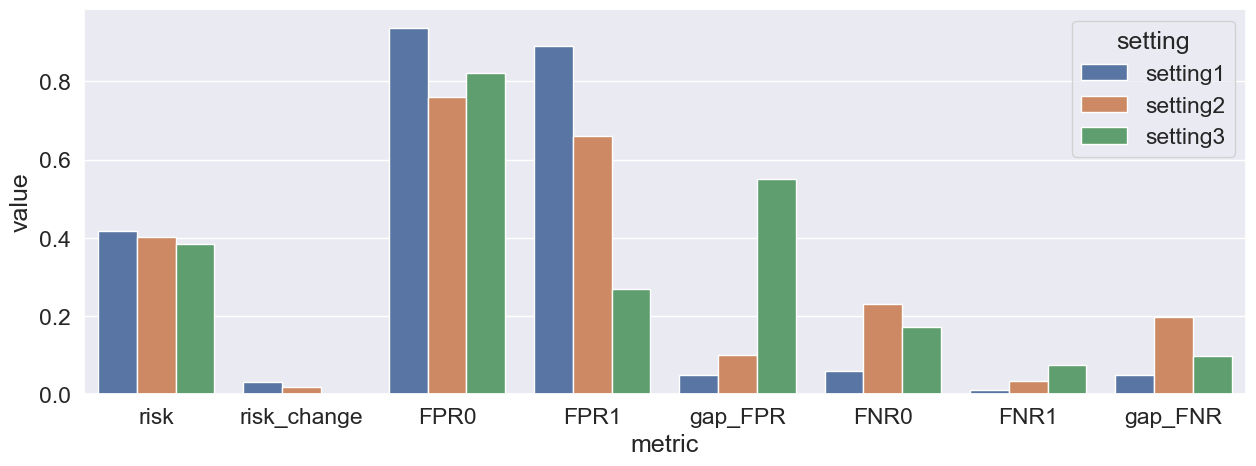

In [189]:
# Plot values for the optimal fair predictors across settings
plt.figure(figsize=(15,5))
sns.set_theme(font_scale = 1.5)
g = sns.barplot(x = 'metric', y = 'value', hue = 'setting', data = metrics_best)
g.get_figure().savefig(os.path.join(FIGPATH, 'task1/optimal_predictors.pdf'))

In [ ]:
# risk_change1 = metrics_best_1.loc[metrics_best_1['metric'] == 'risk_change', 'value'].values[0]
# risk_change2 = metrics_best_2.loc[metrics_best_2['metric'] == 'risk_change', 'value'].values[0]
# risk_change3 = metrics_best_3.loc[metrics_best_3['metric'] == 'risk_change', 'value'].values[0]

## Get estimated fair predictors: doubly robust

In [ ]:
n_arr = [100, 200, 500, 1000, 5000, 20000]
mc_reps = 500
noise_coef = 30

### Setting 1: equal epsilon values 

In [25]:
noise_coef = 30
res1 = [simulate_task1(nn, mc_reps, noise_coef, data_params, epsilon_pos = 0.05,
                   epsilon_neg = 0.05) for nn in n_arr]

Simulating theta-hat for sample size 100 with 500 repetitions...


/Users/Alan/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Simulating theta-hat for sample size 200 with 500 repetitions...
Simulating theta-hat for sample size 500 with 500 repetitions...
Simulating theta-hat for sample size 1000 with 500 repetitions...
Simulating theta-hat for sample size 5000 with 500 repetitions...
Simulating theta-hat for sample size 20000 with 500 repetitions...


In [ ]:
metrics1 = metrics_sim_task1_to_df(res1, n_arr, 'Setting1', data_val, ci=None)
metrics1 = add_reference_values(metrics1, metrics_best_1, new_col='optimal_value')
metrics1.to_csv(os.path.join(OUTPATH, 'task1/metrics1.csv'), index = False)

### Setting 2: different epsilon values

In [36]:
res2 = [simulate_task1(nn, mc_reps, noise_coef, data_params, epsilon_pos = 0.10,
                   epsilon_neg = 0.20) for nn in n_arr]
with open(os.path.join(OUTPATH, 'task1/res2.pickle'), 'wb') as file_out:
    pickle.dump(res2, file_out)

Simulating theta-hat for sample size 100 with 500 repetitions...


/Users/Alan/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Simulating theta-hat for sample size 200 with 500 repetitions...
Simulating theta-hat for sample size 500 with 500 repetitions...
Simulating theta-hat for sample size 1000 with 500 repetitions...
Simulating theta-hat for sample size 5000 with 500 repetitions...
Simulating theta-hat for sample size 20000 with 500 repetitions...


In [38]:
metrics2 = metrics_sim_task1_to_df(res2, n_arr, 'Setting2', data_val, ci = None)
metrics2 = add_reference_values(metrics2, metrics_best_2, new_col='optimal_value')
metrics2.to_csv(os.path.join(OUTPATH, 'task1/metrics2.csv'), index = False)

Evaluating θ metrics:   1%|          | 20/3000 [00:00<01:14, 39.80it/s]/Users/Alan/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Evaluating θ metrics:   6%|▌         | 180/3000 [00:09<02:14, 20.96it/s]/Users/Alan/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Evaluating θ metrics:  25%|██▌       | 750/3000 [00:36<01:43, 21.80it/s]/Users/Alan/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Evalu

### Setting 3: no fairness constraints

In [40]:
res3 = [simulate_task1(nn, mc_reps, noise_coef, data_params, epsilon_pos = 1.0,
                   epsilon_neg = 1.0) for nn in n_arr]
with open(os.path.join(OUTPATH, 'task1/res3.pickle'), 'wb') as file_out:
    pickle.dump(res3, file_out)

Simulating theta-hat for sample size 100 with 500 repetitions...


/Users/Alan/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Simulating theta-hat for sample size 200 with 500 repetitions...
Simulating theta-hat for sample size 500 with 500 repetitions...
Simulating theta-hat for sample size 1000 with 500 repetitions...
Simulating theta-hat for sample size 5000 with 500 repetitions...
Simulating theta-hat for sample size 20000 with 500 repetitions...


In [ ]:
metrics3 = metrics_sim_task1_to_df(res3, n_arr, 'Setting3', data_val, ci=None)
metrics3 = add_reference_values(metrics3, metrics_best_3, new_col='optimal_value')
metrics3.to_csv(os.path.join(OUTPATH, 'task1/metrics3.csv'), index = False)

## Plot combined results: doubly robust

### Unscaled

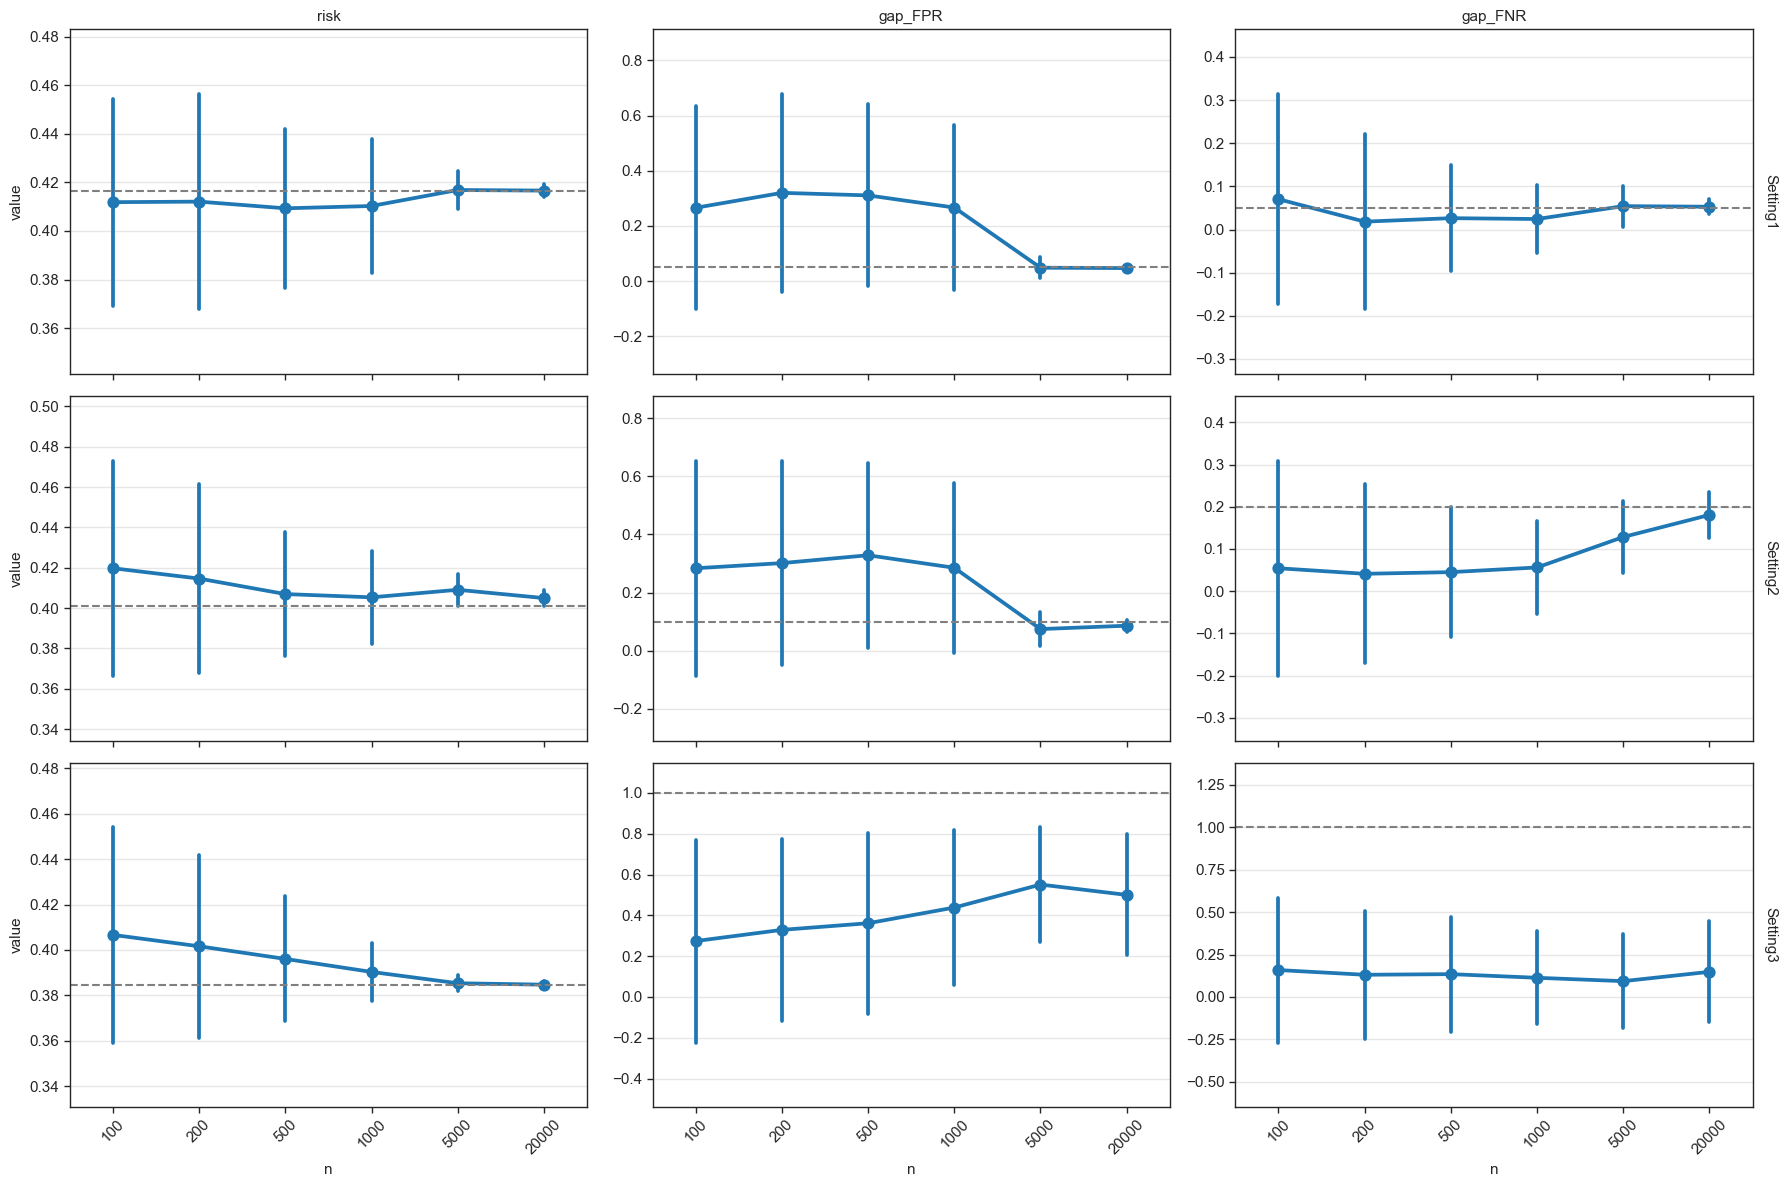

In [523]:
metrics_comb = pd.concat([metrics1, metrics2, metrics3])
metrics_comb.to_csv(os.path.join(OUTPATH, 'task1/metrics_combined_dr.csv'), index = False)

plot_metrics(metrics_comb, row='setting', col='metric',
              row_order=['Setting1', 'Setting2', 'Setting3'],
              col_order=['risk', 'gap_FPR', 'gap_FNR'],
              reference_col='optimal_value',
              height=4, aspect=1.5)

### Scaled by $n^{0.25}$

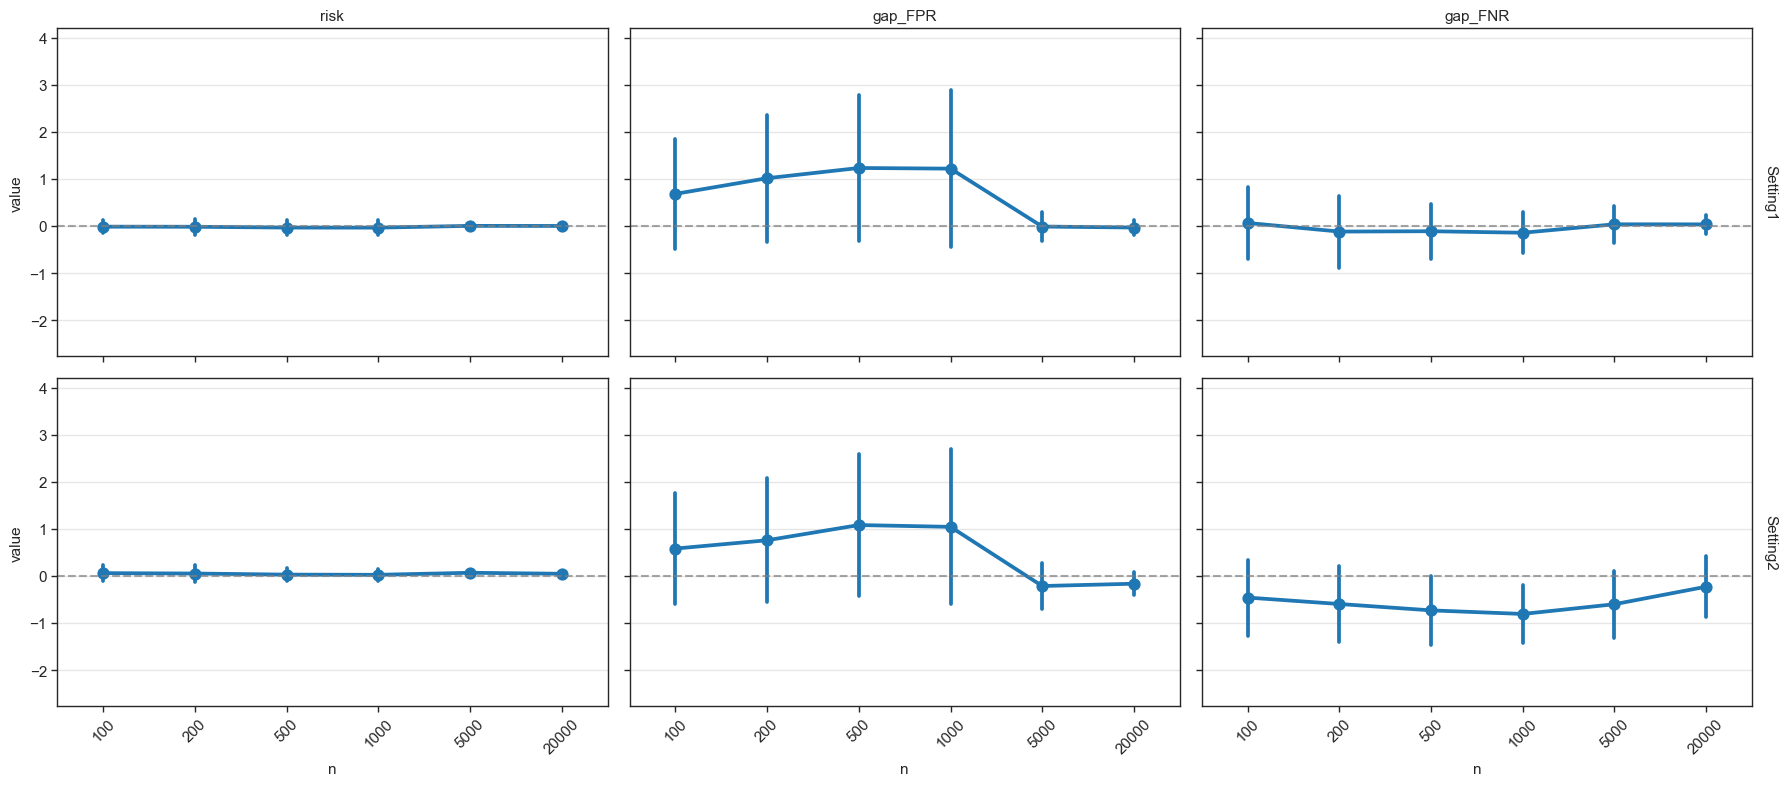

In [515]:
metrics_comb_25 = transform_metrics(metrics_comb, reference_col='optimal_value', scale=0.25)
metrics_comb_25.to_csv(os.path.join(OUTPATH, 'task1/metrics_comb_25.csv'), index = False)

plot_metrics(metrics_comb_25, row='setting', col='metric',
              row_order=['Setting1', 'Setting2'],
              col_order=['risk', 'gap_FPR', 'gap_FNR'], centered=True,
              height=4, aspect=1.5)

### Scaled by $\sqrt{n}$

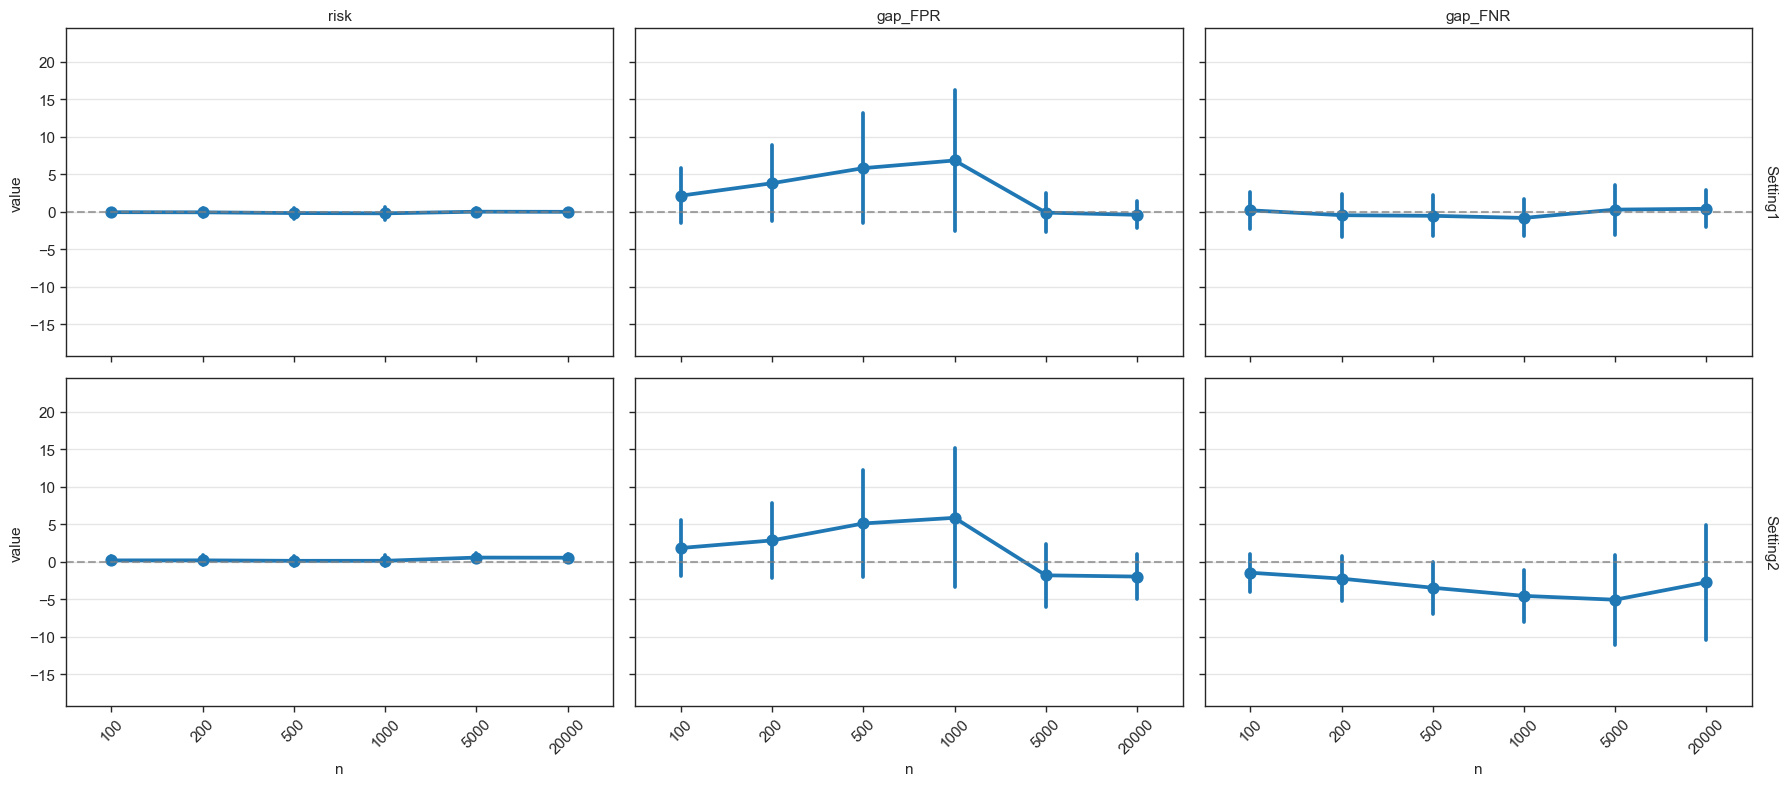

In [454]:
metrics_comb_50 = transform_metrics(metrics_comb, reference_col='optimal_value', scale=0.5)
metrics_comb_50.to_csv(os.path.join(OUTPATH, 'task1/metrics_comb_50.csv'), index = False)

plot_metrics(metrics_comb_50, row='setting', col='metric',
              row_order=['Setting1', 'Setting2'],
              col_order=['risk', 'gap_FPR', 'gap_FNR'], centered=True,
              height=4, aspect=1.5)

### Scaled by $n^{0.75}$

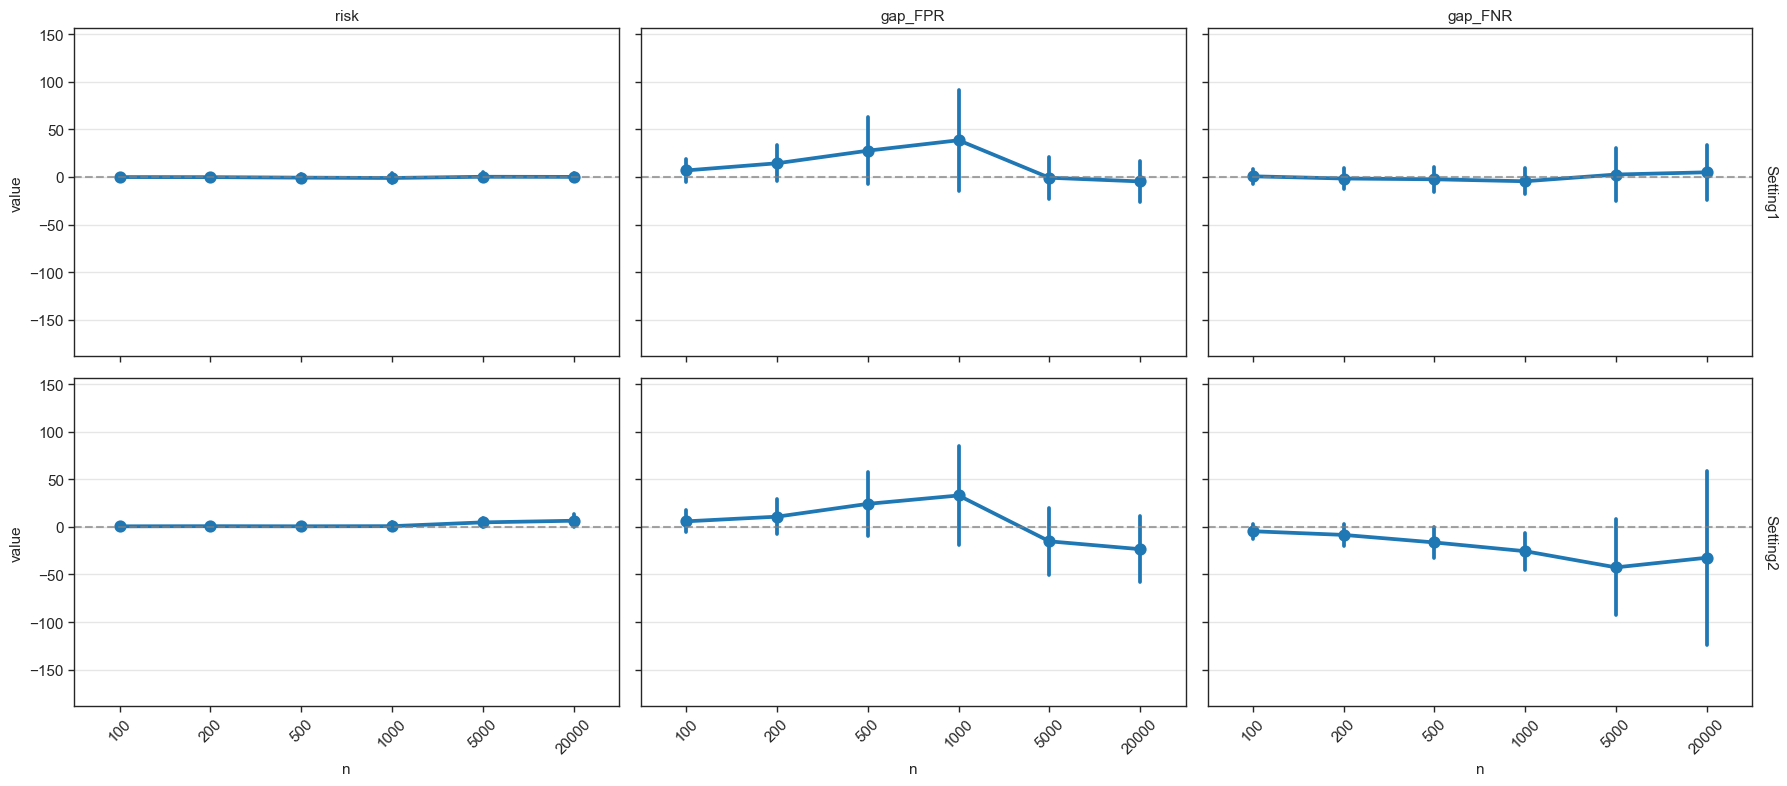

In [455]:
metrics_comb_75 = transform_metrics(metrics_comb, reference_col='optimal_value', scale=0.75)
metrics_comb_75.to_csv(os.path.join(OUTPATH, 'task1/metrics_comb_75.csv'), index = False)

plot_metrics(metrics_comb_75, row='setting', col='metric',
              row_order=['Setting1', 'Setting2'],
              col_order=['risk', 'gap_FPR', 'gap_FNR'], centered=True,
              height=4, aspect=1.5)

### Scaled by $n$

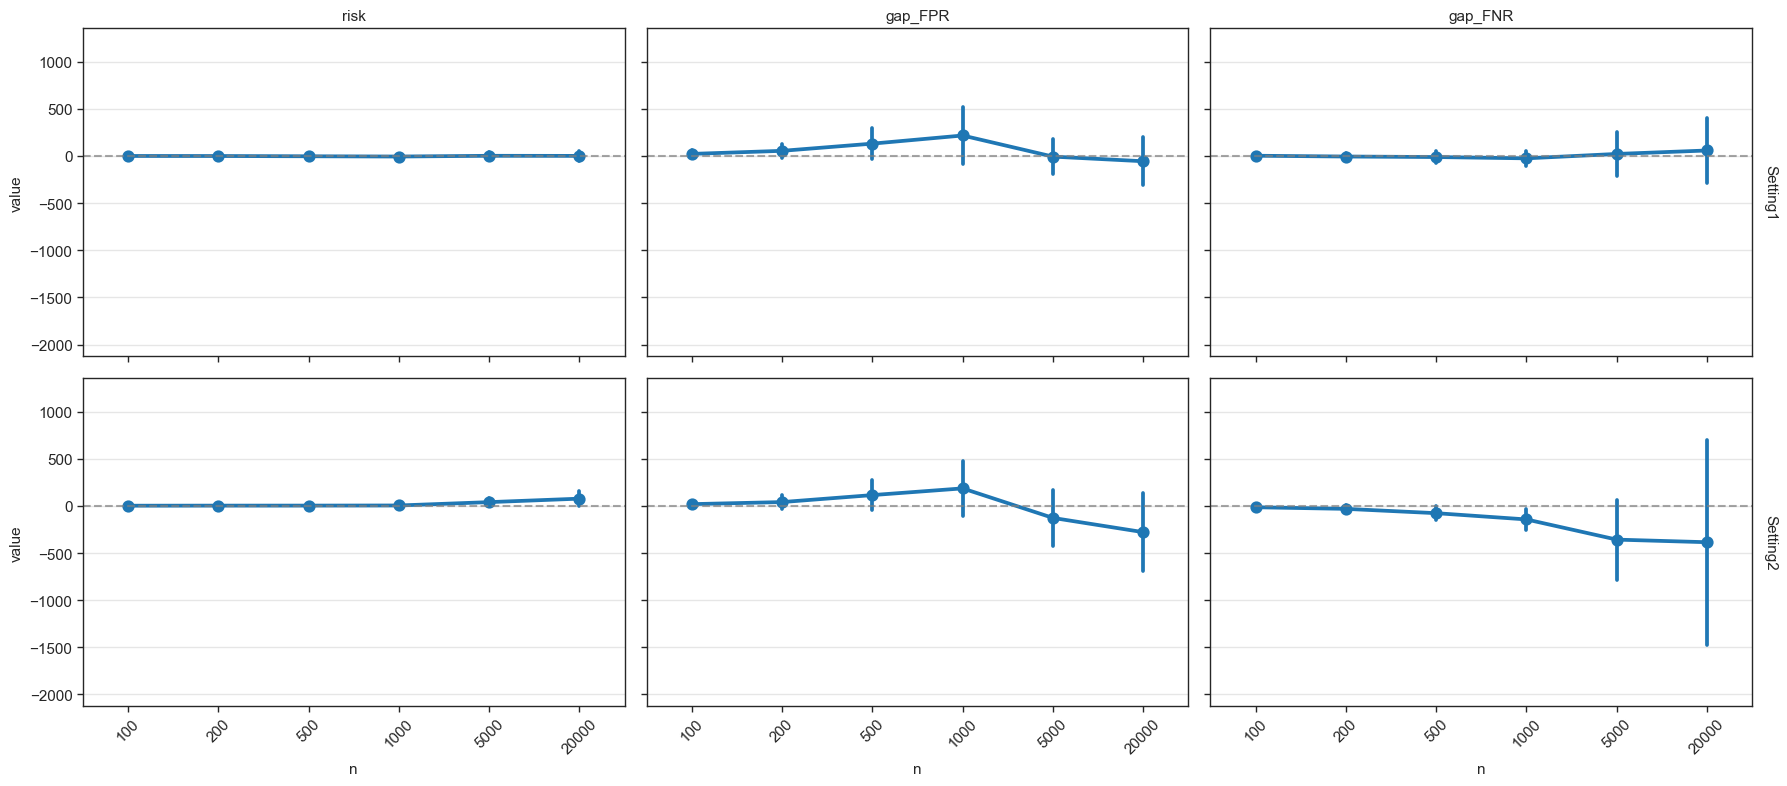

In [456]:
metrics_comb_100 = transform_metrics(metrics_comb, reference_col='optimal_value', scale=1)
metrics_comb_100.to_csv(os.path.join(OUTPATH, 'task1/metrics_comb_100.csv'), index = False)

plot_metrics(metrics_comb_100, row='setting', col='metric',
              row_order=['Setting1', 'Setting2'],
              col_order=['risk', 'gap_FPR', 'gap_FNR'], centered=True,
              height=4, aspect=1.5)

## Get estimated fair predictors: plugin

In [ ]:
## Same parameters as for the doubly robust simulations
n_arr = [100, 200, 500, 1000, 5000, 20000]
mc_reps = 500
noise_coef = 30

### Setting 1: equal epsilon values

In [173]:
res1_pi = [simulate_task1(nn, mc_reps, noise_coef, data_params, epsilon_pos = 0.05,
                   epsilon_neg = 0.05, outcome = 'muhat0') for nn in n_arr]
with open(os.path.join(OUTPATH, 'task1/res1_pi.pickle'), 'wb') as file_out:
    pickle.dump(res1_pi, file_out)

Simulating theta-hat for sample size 100 with 500 repetitions...


/Users/Alan/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Simulating theta-hat for sample size 200 with 500 repetitions...
Simulating theta-hat for sample size 500 with 500 repetitions...
Simulating theta-hat for sample size 1000 with 500 repetitions...
Simulating theta-hat for sample size 5000 with 500 repetitions...
Simulating theta-hat for sample size 20000 with 500 repetitions...


In [ ]:
metrics1_pi = metrics_sim_task1_to_df(res1_pi, n_arr, 'Setting1', data_val)
metrics1_pi = add_reference_values(metrics1_pi, metrics_best_1, new_col='optimal_value')
metrics1_pi.to_csv(os.path.join(OUTPATH, 'task1/metrics1_pi.csv'), index = False)

### Setting 2: different epsilon values

In [177]:
res2_pi = [simulate_task1(nn, mc_reps, noise_coef, data_params, epsilon_pos = 0.10,
                   epsilon_neg = 0.20, outcome = 'muhat0') for nn in n_arr]
with open(os.path.join(OUTPATH, 'task1/res2_pi.pickle'), 'wb') as file_out:
    pickle.dump(res1_pi, file_out)

Simulating theta-hat for sample size 100 with 500 repetitions...


/Users/Alan/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Simulating theta-hat for sample size 200 with 500 repetitions...
Simulating theta-hat for sample size 500 with 500 repetitions...
Simulating theta-hat for sample size 1000 with 500 repetitions...
Simulating theta-hat for sample size 5000 with 500 repetitions...
Simulating theta-hat for sample size 20000 with 500 repetitions...


In [ ]:
metrics2_pi = metrics_sim_task1_to_df(res2_pi, n_arr, 'Setting2', data_val)
metrics2_pi = add_reference_values(metrics2_pi, metrics_best_2, new_col='optimal_value')
metrics2_pi.to_csv(os.path.join(OUTPATH, 'task1/metrics2_pi.csv'), index = False)

### Setting 3: no fairness constraints

In [179]:
res3_pi = [simulate_task1(nn, mc_reps, noise_coef, data_params, epsilon_pos = 1.0,
                   epsilon_neg = 1.0, outcome = 'muhat0') for nn in n_arr]
with open(os.path.join(OUTPATH, 'task1/res3_pi.pickle'), 'wb') as file_out:
    pickle.dump(res3_pi, file_out)

Simulating theta-hat for sample size 100 with 500 repetitions...


/Users/Alan/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Simulating theta-hat for sample size 200 with 500 repetitions...
Simulating theta-hat for sample size 500 with 500 repetitions...
Simulating theta-hat for sample size 1000 with 500 repetitions...
Simulating theta-hat for sample size 5000 with 500 repetitions...
Simulating theta-hat for sample size 20000 with 500 repetitions...


In [ ]:
metrics3_pi = metrics_sim_task1_to_df(res3_pi, n_arr, 'Setting3', data_val)
metrics3_pi = add_reference_values(metrics3_pi, metrics_best_3, new_col='optimal_value')
metrics3_pi.to_csv(os.path.join(OUTPATH, 'task1/metrics3_pi.csv'), index = False)

## Plot combined results: plugin

### Unscaled

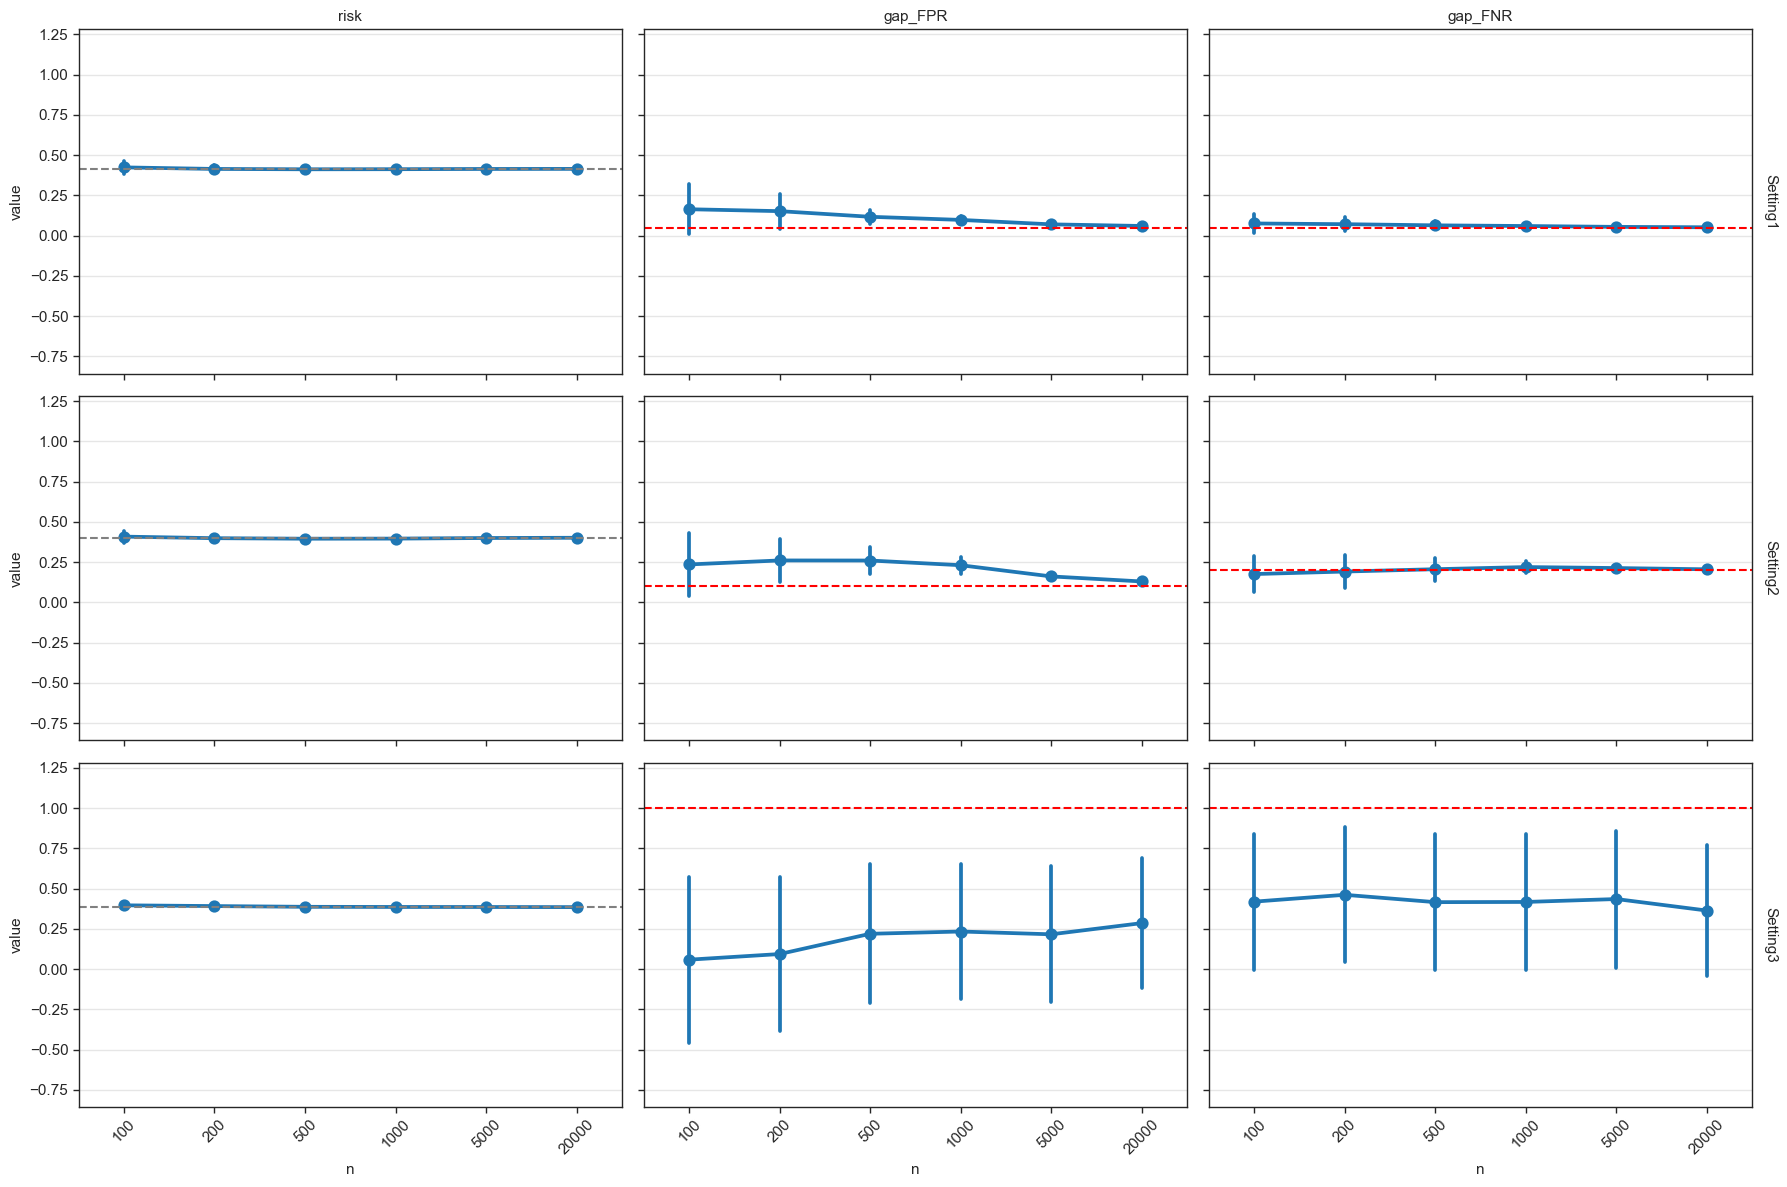

In [513]:
metrics_comb_pi = pd.concat([metrics1_pi, metrics2_pi, metrics3_pi])
metrics_comb_pi.to_csv(os.path.join(OUTPATH, 'task1/metrics_combined_pi.csv'), index = False)

plot_metrics(metrics_comb_pi, row='setting', col='metric',
              row_order=['Setting1', 'Setting2', 'Setting3'],
              col_order=['risk', 'gap_FPR', 'gap_FNR'],
              reference_col='optimal_value',
              height=4, aspect=1.5)

### Scaled by $n^{0.25}$

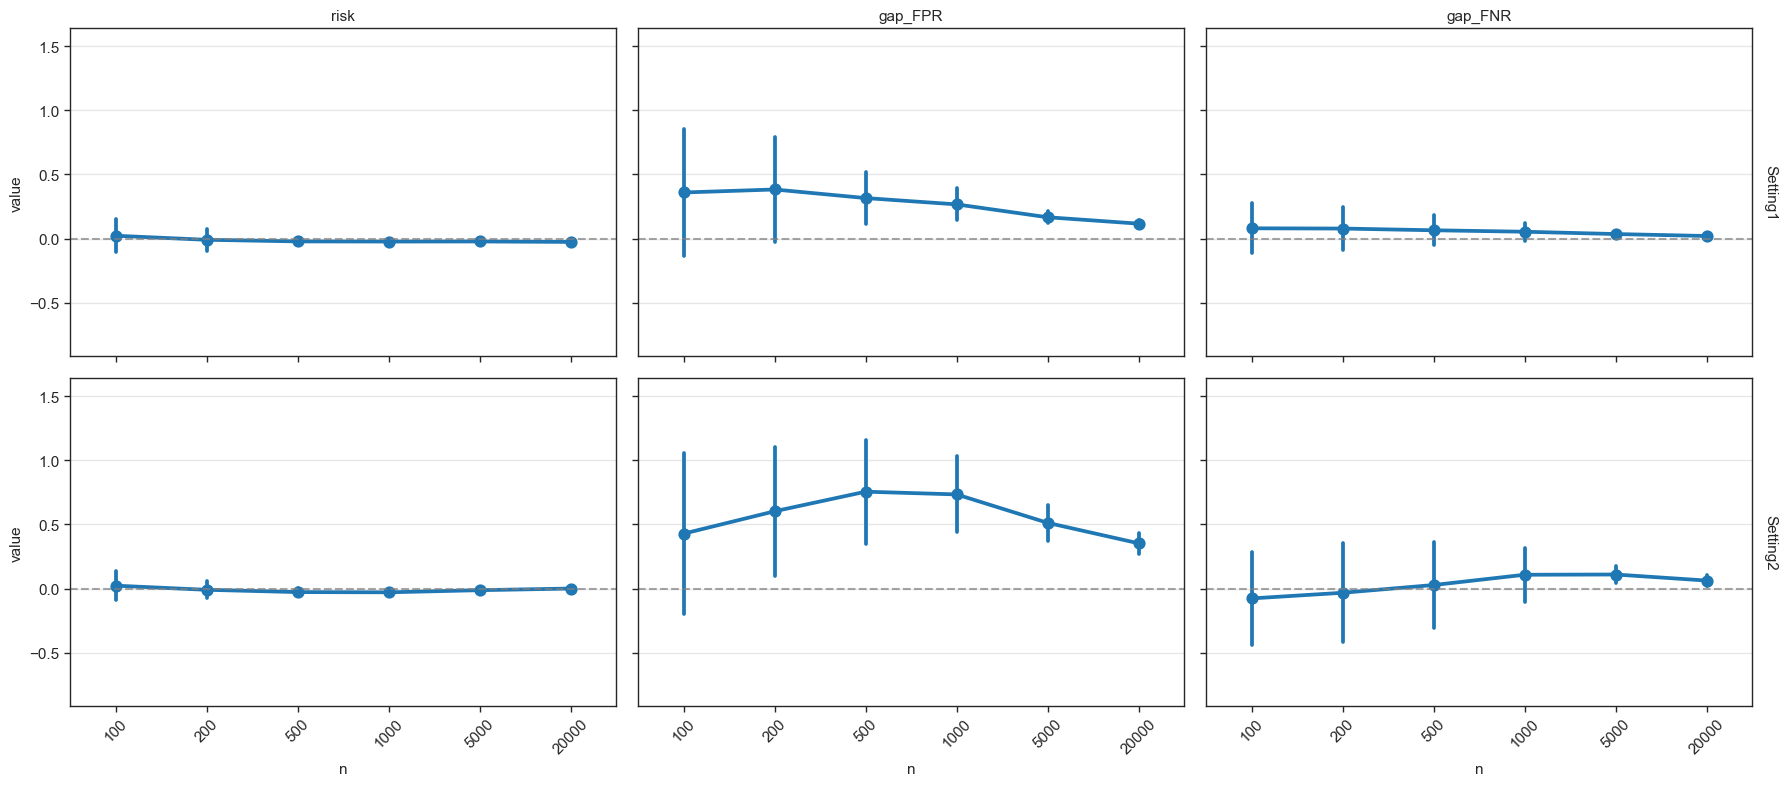

In [475]:
metrics_comb_25_pi = transform_metrics(metrics_comb_pi, reference_col='optimal_value', scale=0.25)
metrics_comb_25_pi.to_csv(os.path.join(OUTPATH, 'task1/metrics_comb_25_pi.csv'), index = False)

plot_metrics(metrics_comb_25_pi, row='setting', col='metric',
              row_order=['Setting1', 'Setting2'],
              col_order=['risk', 'gap_FPR', 'gap_FNR'], centered=True,
              height=4, aspect=1.5)

### Scaled by $\sqrt{n}$

okay


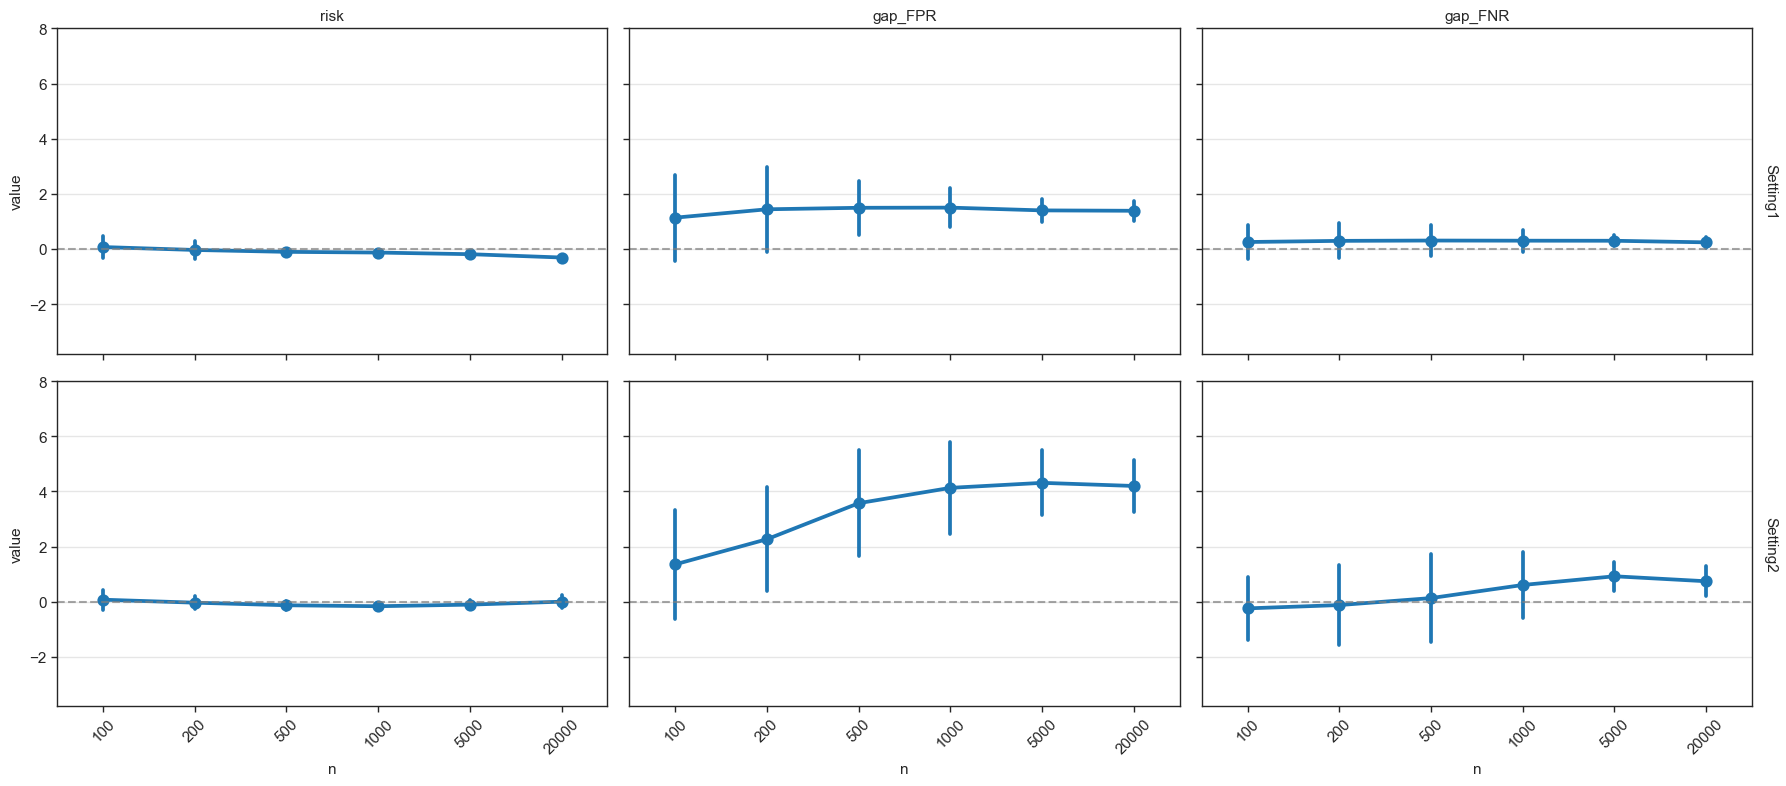

In [512]:
metrics_comb_50_pi = transform_metrics(metrics_comb_pi, reference_col='optimal_value', scale=0.50)
metrics_comb_50_pi.to_csv(os.path.join(OUTPATH, 'task1/metrics_comb_50_pi.csv'), index = False)

plot_metrics(metrics_comb_50_pi, row='setting', col='metric',
              row_order=['Setting1', 'Setting2'],
              col_order=['risk', 'gap_FPR', 'gap_FNR'], centered=True,
              height=4, aspect=1.5)

### Scaled by $n^{0.75}$

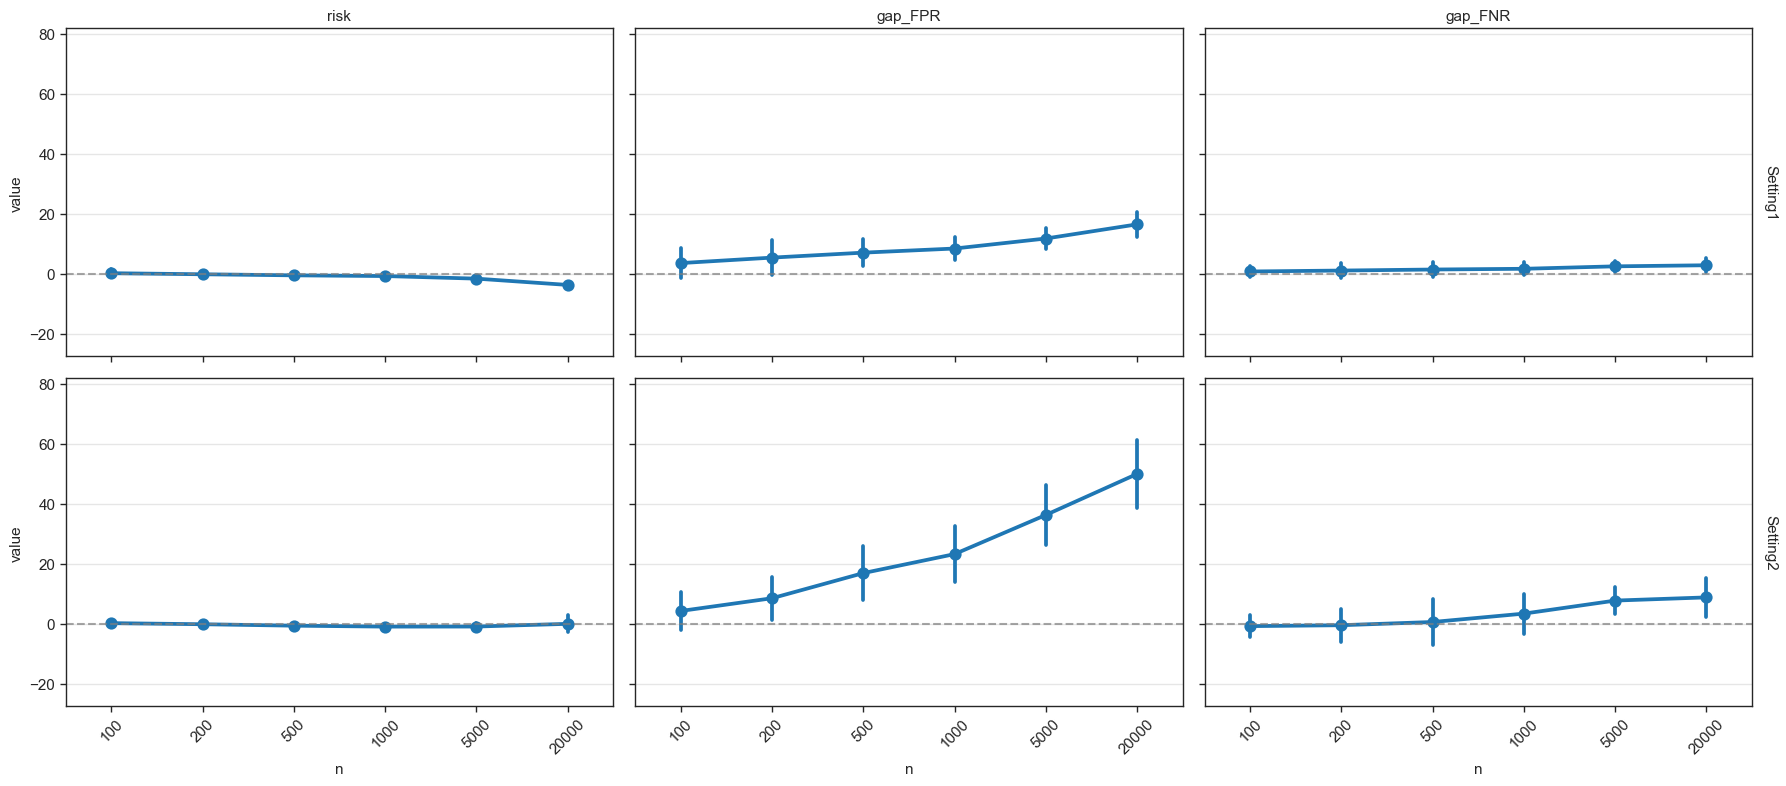

In [477]:
metrics_comb_75_pi = transform_metrics(metrics_comb_pi, reference_col='optimal_value', scale=0.75)
metrics_comb_75_pi.to_csv(os.path.join(OUTPATH, 'task1/metrics_comb_75_pi.csv'), index = False)

plot_metrics(metrics_comb_75_pi, row='setting', col='metric',
              row_order=['Setting1', 'Setting2'],
              col_order=['risk', 'gap_FPR', 'gap_FNR'], centered=True,
              height=4, aspect=1.5)

### Scaled by $n$

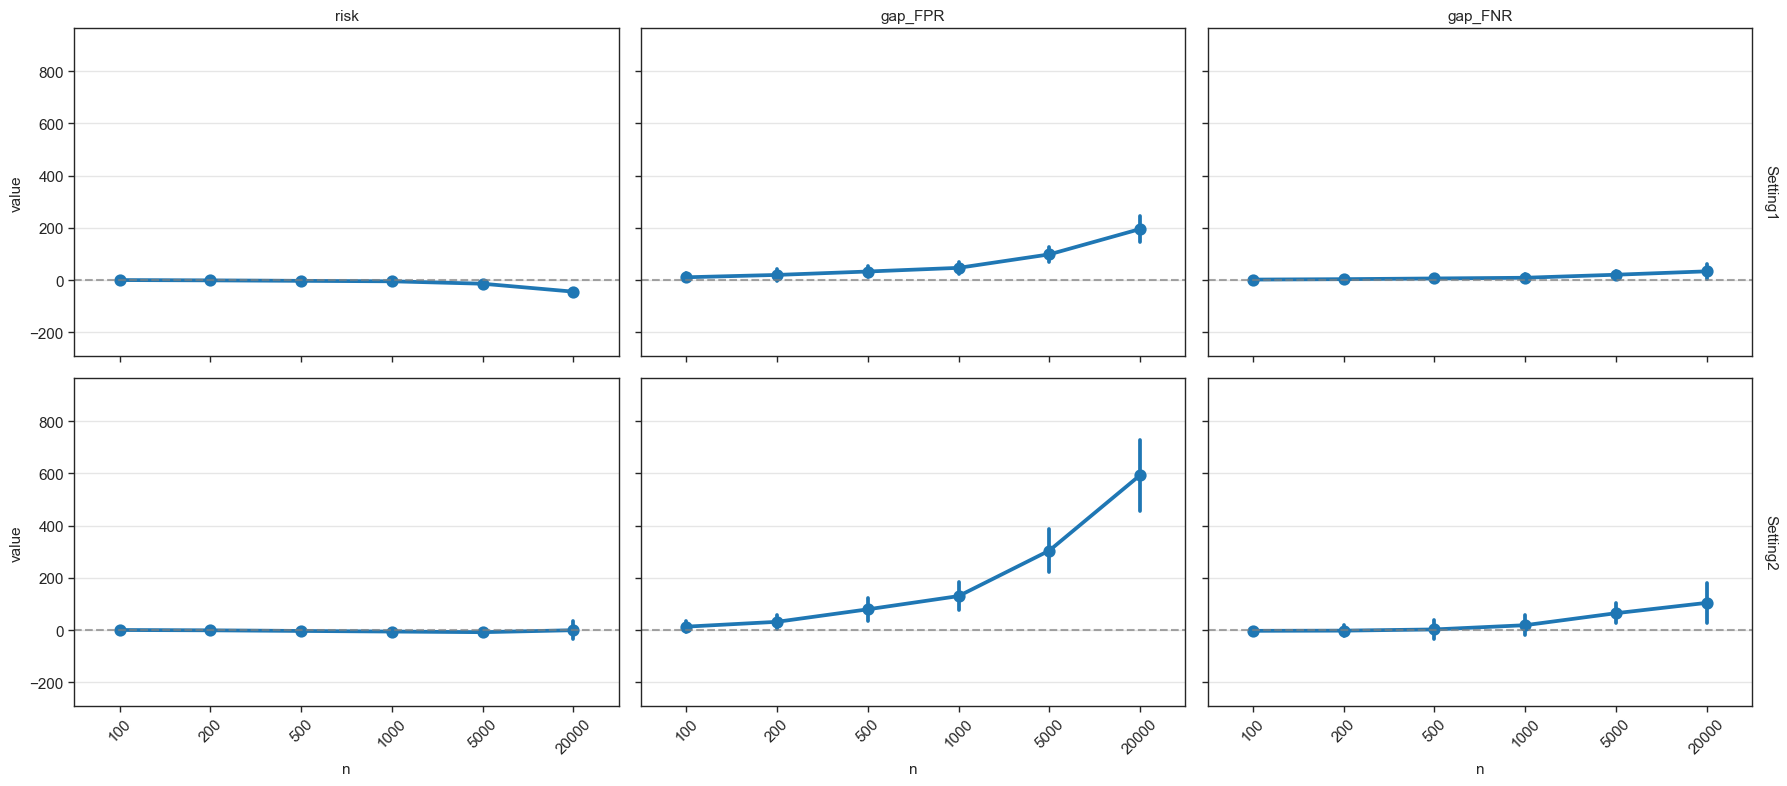

In [478]:
metrics_comb_100_pi = transform_metrics(metrics_comb_pi, reference_col='optimal_value', scale=1)
metrics_comb_100_pi.to_csv(os.path.join(OUTPATH, 'task1/metrics_comb_100_pi.csv'), index = False)

plot_metrics(metrics_comb_100_pi, row='setting', col='metric',
              row_order=['Setting1', 'Setting2'],
              col_order=['risk', 'gap_FPR', 'gap_FNR'], centered=True,
              height=4, aspect=1.5)

# Task (2) Simulations

## Read in previous results

In [ ]:
# ## Read in previous results
# data_val = pd.read_csv('../out/data_val.csv')

# metrics_est1 = pd.read_csv('../out/task2/metrics_est1.csv')
# metrics_est2 = pd.read_csv('../out/task2/metrics_est2.csv')
# metrics_est1_pi = pd.read_csv('../out/task2/metrics_est1_pi.csv')
# metrics_est2_pi = pd.read_csv('../out/task2/metrics_est2_pi.csv')

# metrics_post1 = pd.read_csv('../out/task2/metrics_post1.csv')
# metrics_post2 = pd.read_csv('../out/task2/metrics_post2.csv')

In [ ]:
## Metrics for the input predictor, for potential plotting purposes
metrics_pre = metrics_post_simple([0, 1, 0, 1], data_val, outcome = 'mu0', ci=0.95)
risk_pre = metrics_pre.query("metric=='risk'")['value'].values[0]

## Simulations setup

In [408]:
theta1 = [0.64, 0.39, 0.53, 0.46]           # Scenario 1
# theta2 = [0.74, 0.97, 0.05, 0.77]           # Scenario 2
theta2 = [0.74, 1.0, 0, 0.8]                # Scenario 2
n_arr = [100, 200, 500, 1000, 5000, 20000]  # Sample sizes
mc_reps = 500                               # Monte Carlo iterations
noise_coef = 30                             # Noise coefficient for nuisance parameters in simulations

In [ ]:
# "True" values for the scenarios
metrics_post1 = metrics_post_simple(theta1, data_val, outcome = 'mu0')
metrics_post2 = metrics_post_simple(theta2, data_val, outcome = 'mu0')

metrics_post1.to_csv(os.path.join(OUTPATH, 'task2/metrics_post1.csv'), index = False)
metrics_post2.to_csv(os.path.join(OUTPATH, 'task2/metrics_post2.csv'), index = False)

In [ ]:
# Extract relevant metrics
risk_post1 = metrics_post1.loc[metrics_post1['metric'] == 'risk', 'value'].values[0]
risk_change_post1 = metrics_post1.loc[metrics_post1['metric'] == 'risk_change', 'value'].values[0]
gap_FPR_post1 = metrics_post1.loc[metrics_post1['metric'] == 'gap_FPR', 'value'].values[0]
gap_FNR_post1 = metrics_post1.loc[metrics_post1['metric'] == 'gap_FNR', 'value'].values[0]

risk_post2 = metrics_post2.loc[metrics_post2['metric'] == 'risk', 'value'].values[0]
risk_change_post2 = metrics_post2.loc[metrics_post2['metric'] == 'risk_change', 'value'].values[0]
gap_FPR_post2 = metrics_post2.loc[metrics_post2['metric'] == 'gap_FPR', 'value'].values[0]
gap_FNR_post2 = metrics_post2.loc[metrics_post2['metric'] == 'gap_FNR', 'value'].values[0]

## Estimate metrics: doubly robust

### Scenario 1: equal epsilon values

In [ ]:
metrics_est1 = simulate_task2(theta1, noise_coef, n_arr, mc_reps, data_params,
                            outcome = 'phihat', ci = 0.95, ci_scale = 'logit')
metrics_est1 = add_reference_values(metrics_est1, metrics_post1, new_col='true_value')
metrics_est1['setting'] = 'Setting1'
metrics_est1.to_csv(os.path.join(OUTPATH, 'task2/metrics_est1_logit.csv'), index = False)

In [ ]:
# Get confidence interval coverage
cov_means1 = coverage(metrics_est1, metrics_post1, simplify=True)
cov_means1.to_csv(os.path.join(OUTPATH, 'task2/task2_scenario1_coverage_logit.csv'), index = False)

### Scenario 2: different epsilon values

In [ ]:
metrics_est2 = simulate_task2(theta2, noise_coef, n_arr, mc_reps, data_params,
                            outcome = 'phihat', ci_scale = 'logit')
metrics_est2 = add_reference_values(metrics_est2, metrics_post2, new_col='true_value')
metrics_est2['setting'] = 'Setting2'
metrics_est2.to_csv(os.path.join(OUTPATH, 'task2/metrics_est2_logit.csv'), index = False)

In [285]:
# Get confidence interval coverage
cov_means2 = coverage(metrics_est2, metrics_post2, simplify=True)
cov_means2.to_csv(os.path.join(OUTPATH, 'task2/task2_scenario2_coverage_logit.csv'), index = False)
cov_means2.coverage.median()

0.951

## Plot combined results: doubly robust

### Unscaled

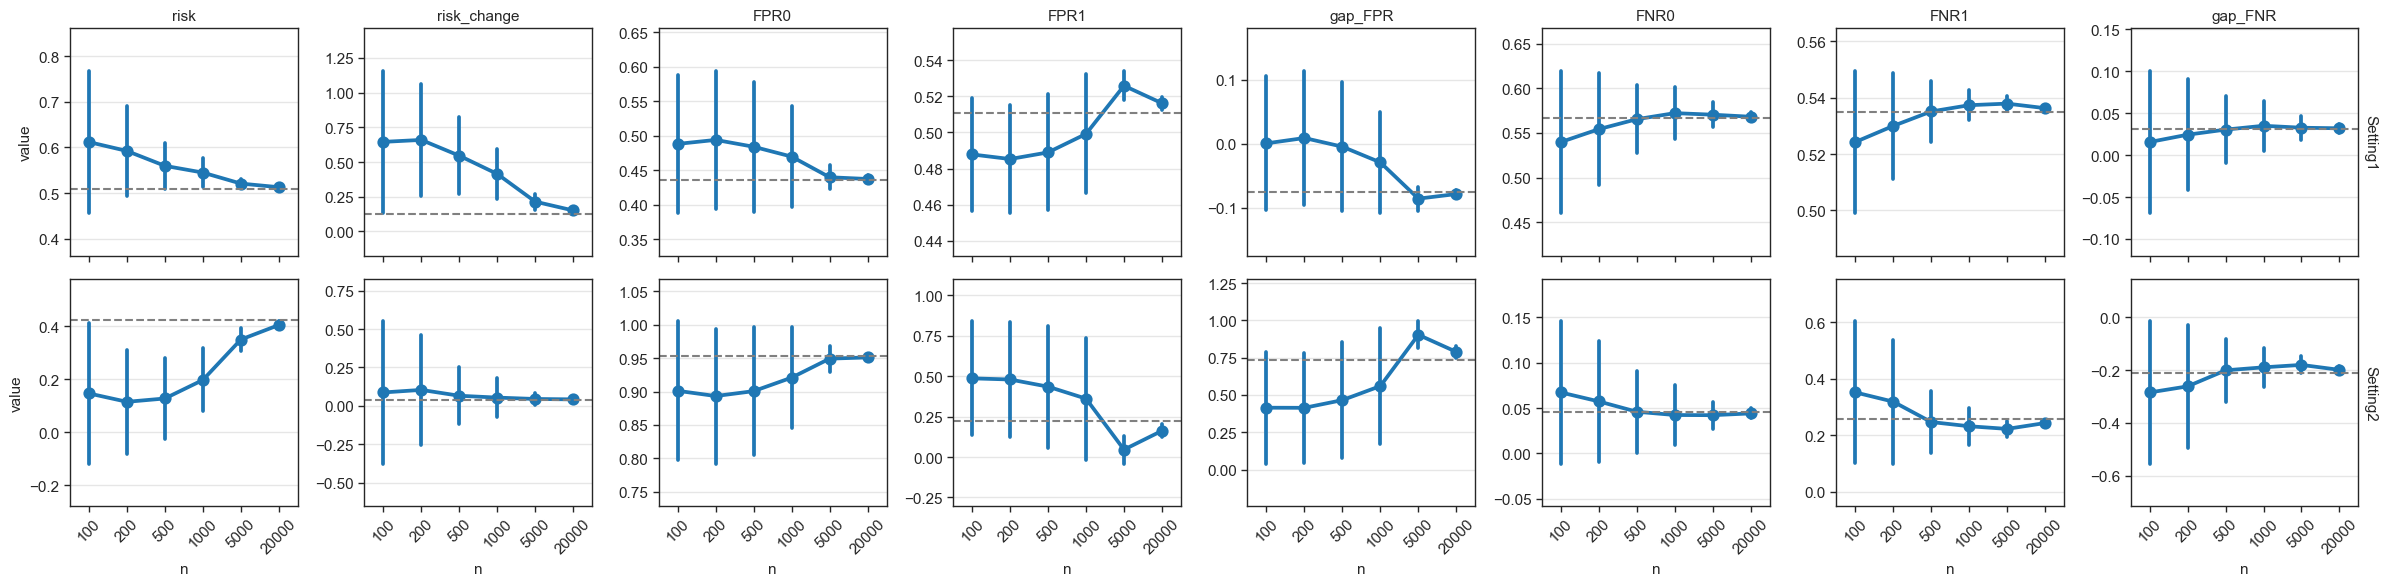

In [539]:
metrics_est_comb = pd.concat([metrics_est1, metrics_est2])
plot_metrics(metrics_est_comb, row='setting', col='metric', reference_col='true_value')

### Scaled by $n^{0.25}$

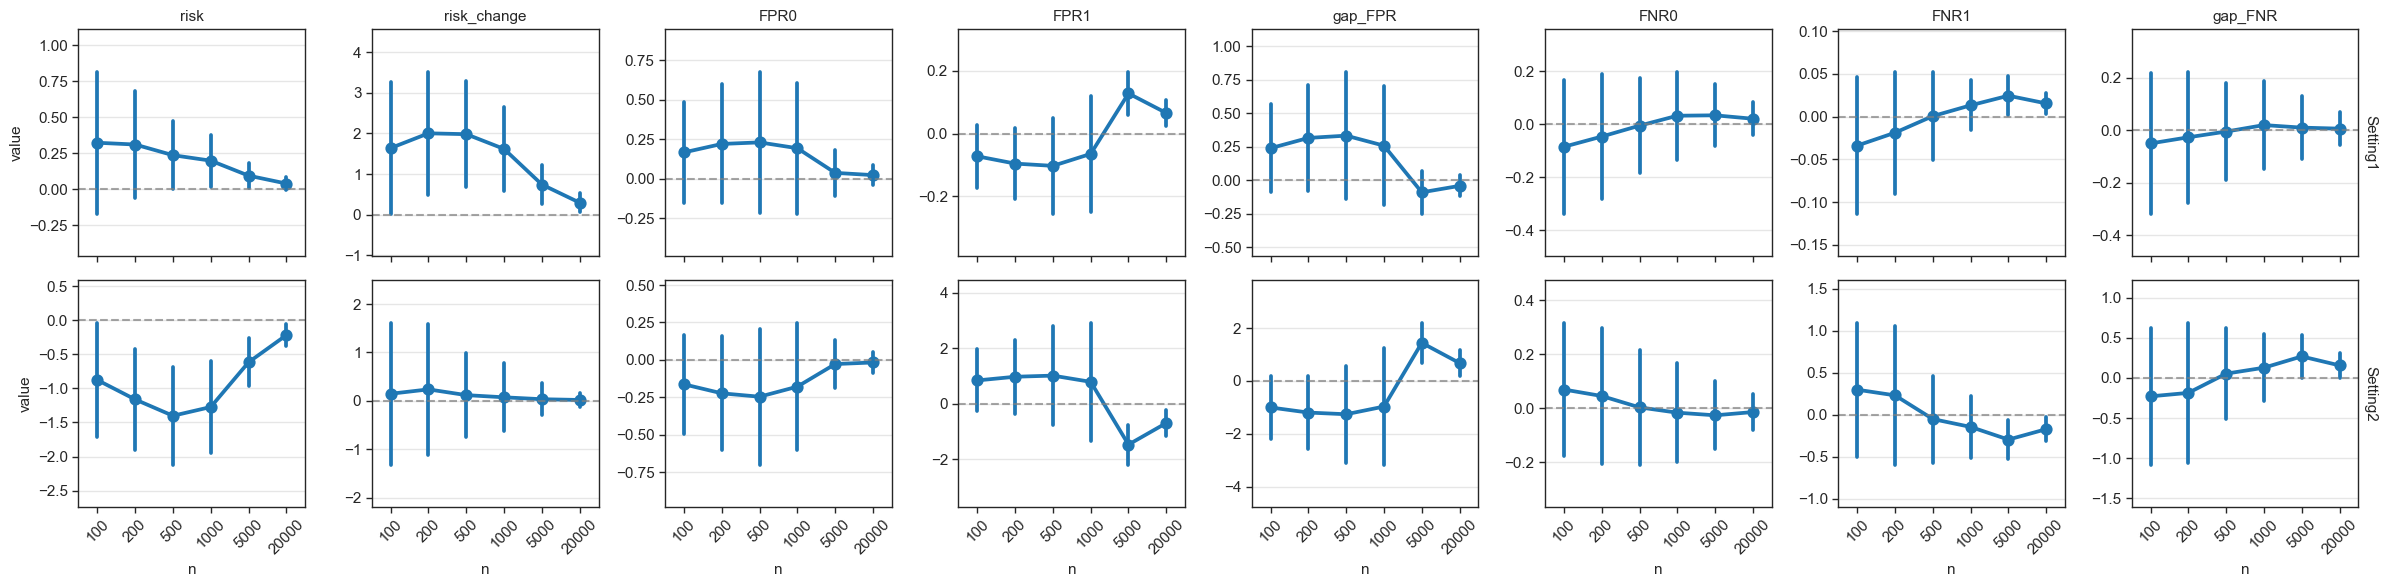

In [541]:
metrics_est_comb_25 = transform_metrics(metrics_est_comb, reference_col='true_value', scale=0.25)
plot_metrics(metrics_est_comb_25, row='setting', col='metric', centered=True)

### Scaled by $\sqrt{n}$

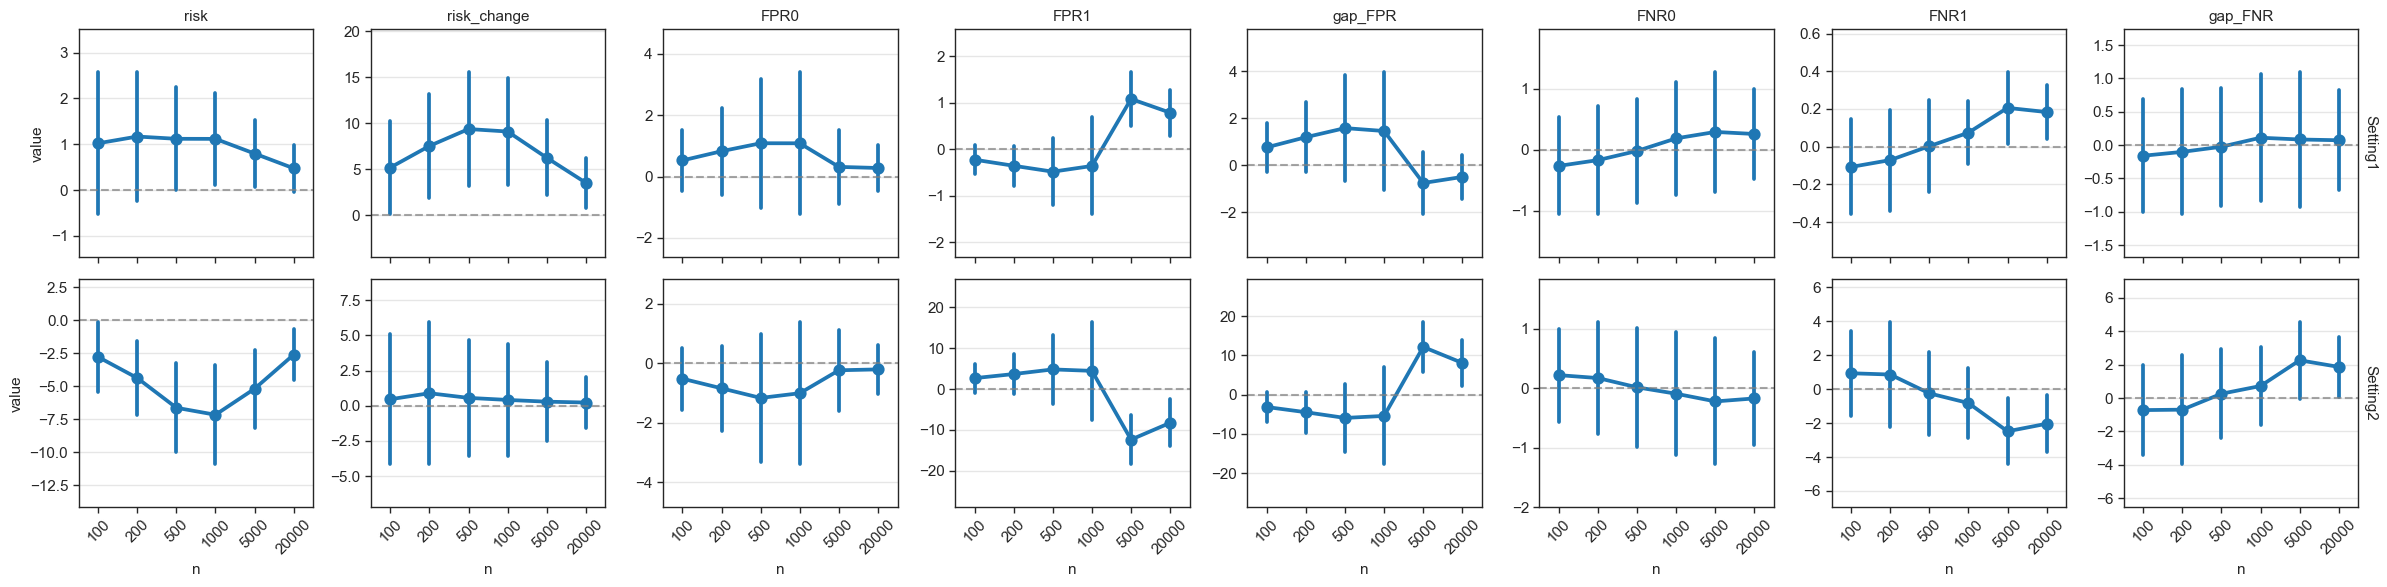

In [542]:
metrics_est_comb_50 = transform_metrics(metrics_est_comb, reference_col='true_value', scale=0.50)
plot_metrics(metrics_est_comb_50, row='setting', col='metric', centered=True)

### Scaled by $n^{0.75}$

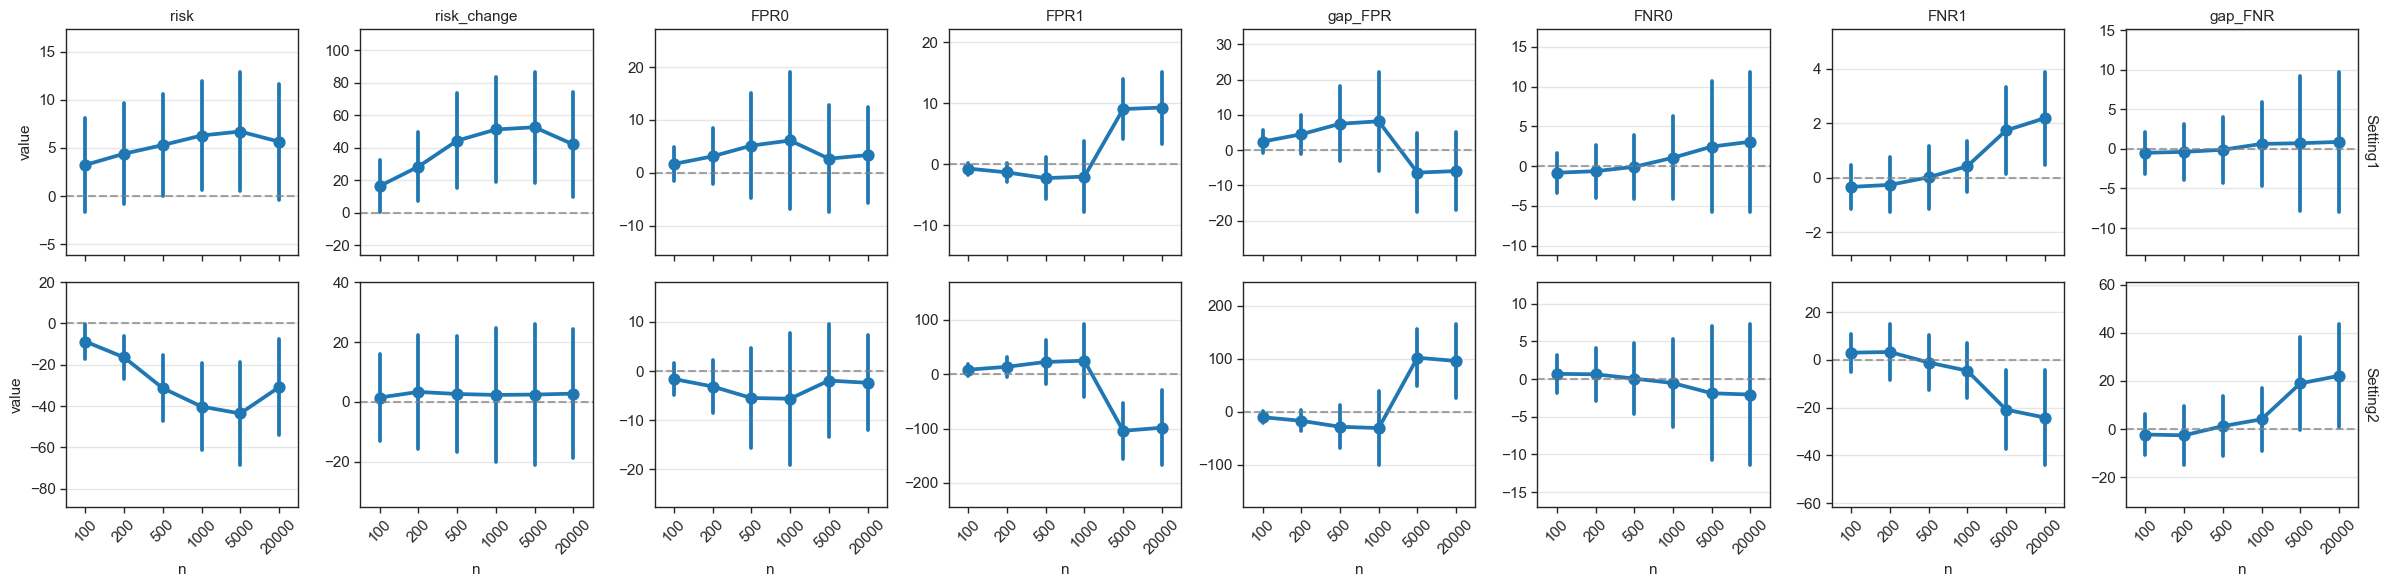

In [543]:
metrics_est_comb_75 = transform_metrics(metrics_est_comb, reference_col='true_value', scale=0.75)
plot_metrics(metrics_est_comb_75, row='setting', col='metric', centered=True)

### Scaled by $n$

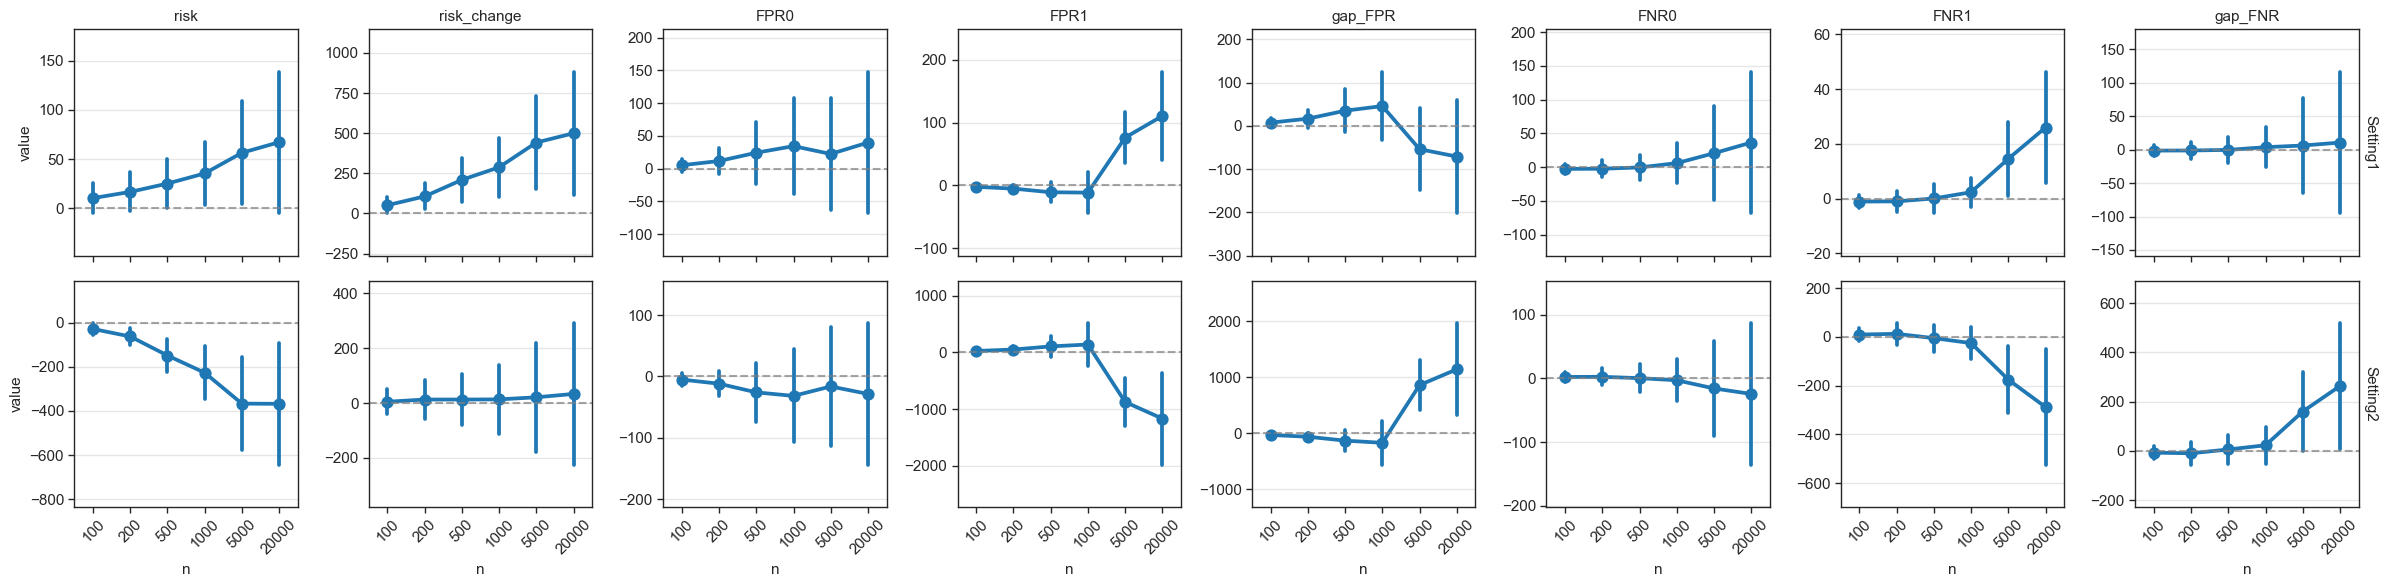

In [544]:
metrics_est_comb_100 = transform_metrics(metrics_est_comb, reference_col='true_value', scale=1.0)
plot_metrics(metrics_est_comb_100, row='setting', col='metric', centered=True)

## Estimate metrics: plugin

### Scenario 1: equal epsilon values

In [ ]:
metrics_est1_pi = simulate_task2(theta1, noise_coef, n_arr, mc_reps, data_params, outcome = 'muhat0')
metrics_est1_pi = add_reference_values(metrics_est1_pi, metrics_post1, new_col='true_value')
metrics_est1_pi['setting'] = 'Setting1'
metrics_est1_pi.to_csv(os.path.join(OUTPATH, 'task2/metrics_est1_pi_logit.csv'), index = False)

### Scenario 2: different epsilon values

In [ ]:
metrics_est2_pi = simulate_task2(theta2, 30, n_arr, mc_reps, data_params, outcome = 'muhat0')
metrics_est2_pi = add_reference_values(metrics_est2_pi, metrics_post2, new_col='true_value')
metrics_est2_pi['setting'] = 'Setting2'
metrics_est2_pi.to_csv(os.path.join(OUTPATH, 'task2/metrics_est2_pi_logit.csv'), index = False)

## Plot combined results: plugin

### Unscaled

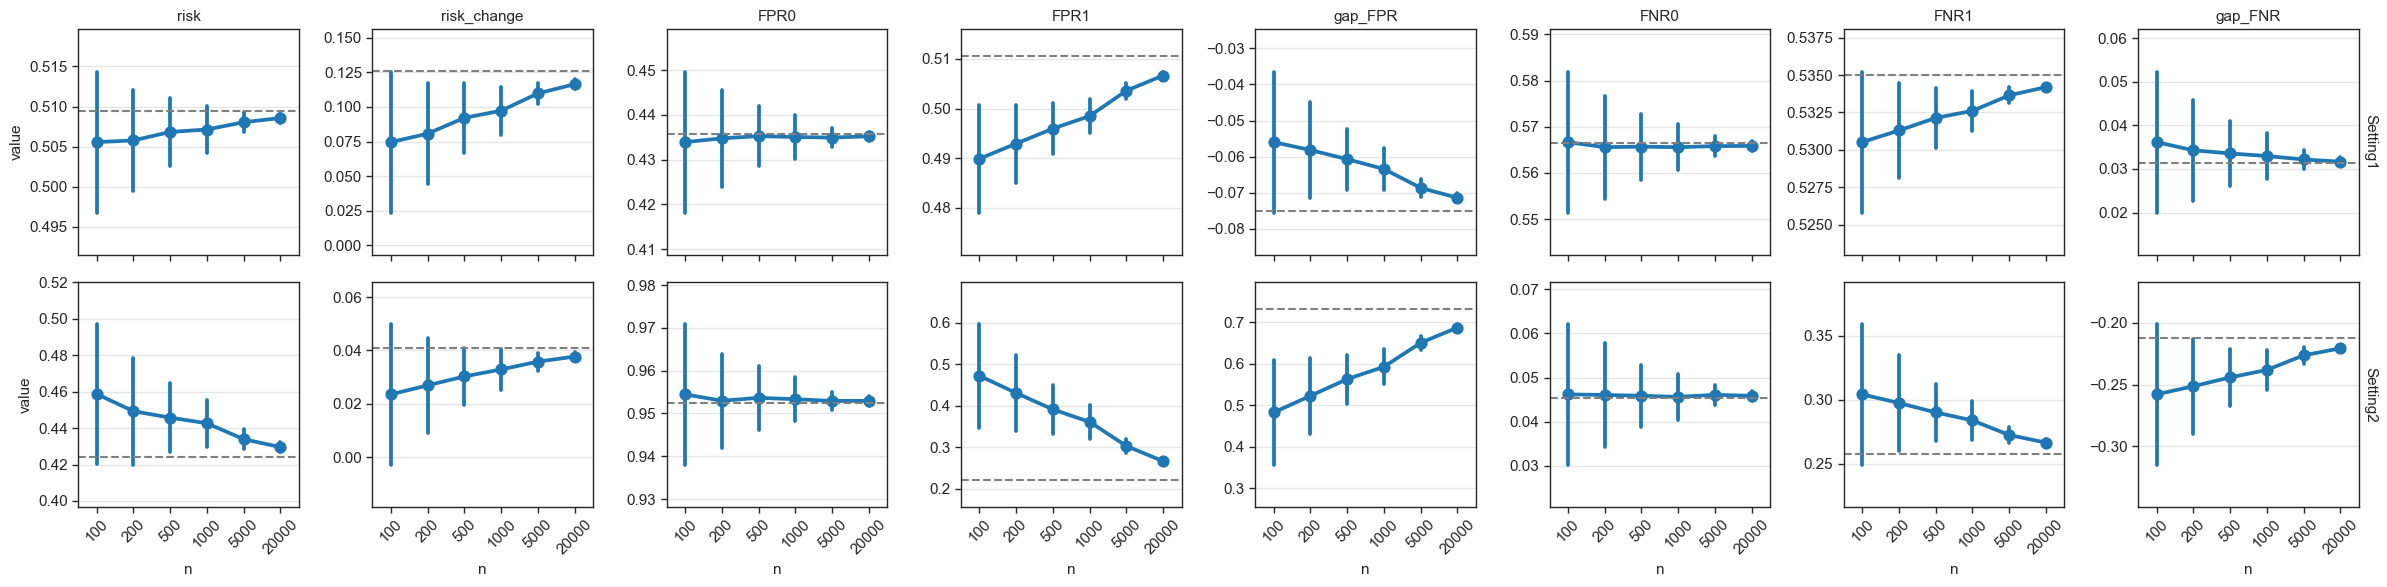

In [550]:
metrics_est_comb_pi = pd.concat([metrics_est1_pi, metrics_est2_pi])
plot_metrics(metrics_est_comb_pi, row='setting', col='metric', reference_col='true_value')

### Scaled by $n^{1/4}$

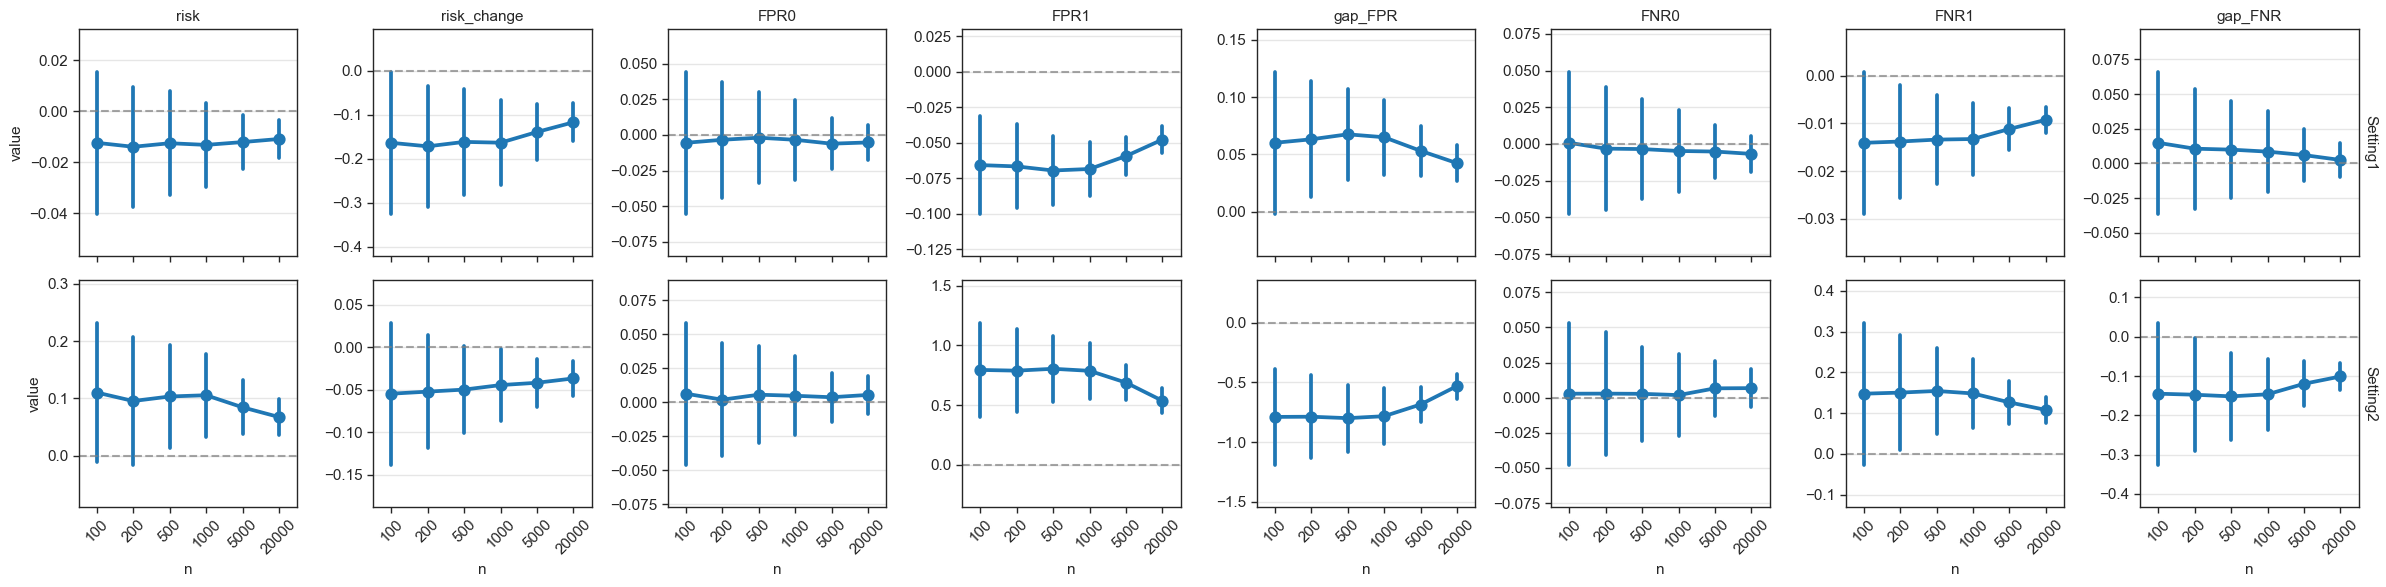

In [551]:
metrics_est_comb_pi_25 = transform_metrics(metrics_est_comb_pi, reference_col='true_value', scale=0.25)
plot_metrics(metrics_est_comb_pi_25, row='setting', col='metric', centered=True)

### Scaled by $\sqrt{n}$

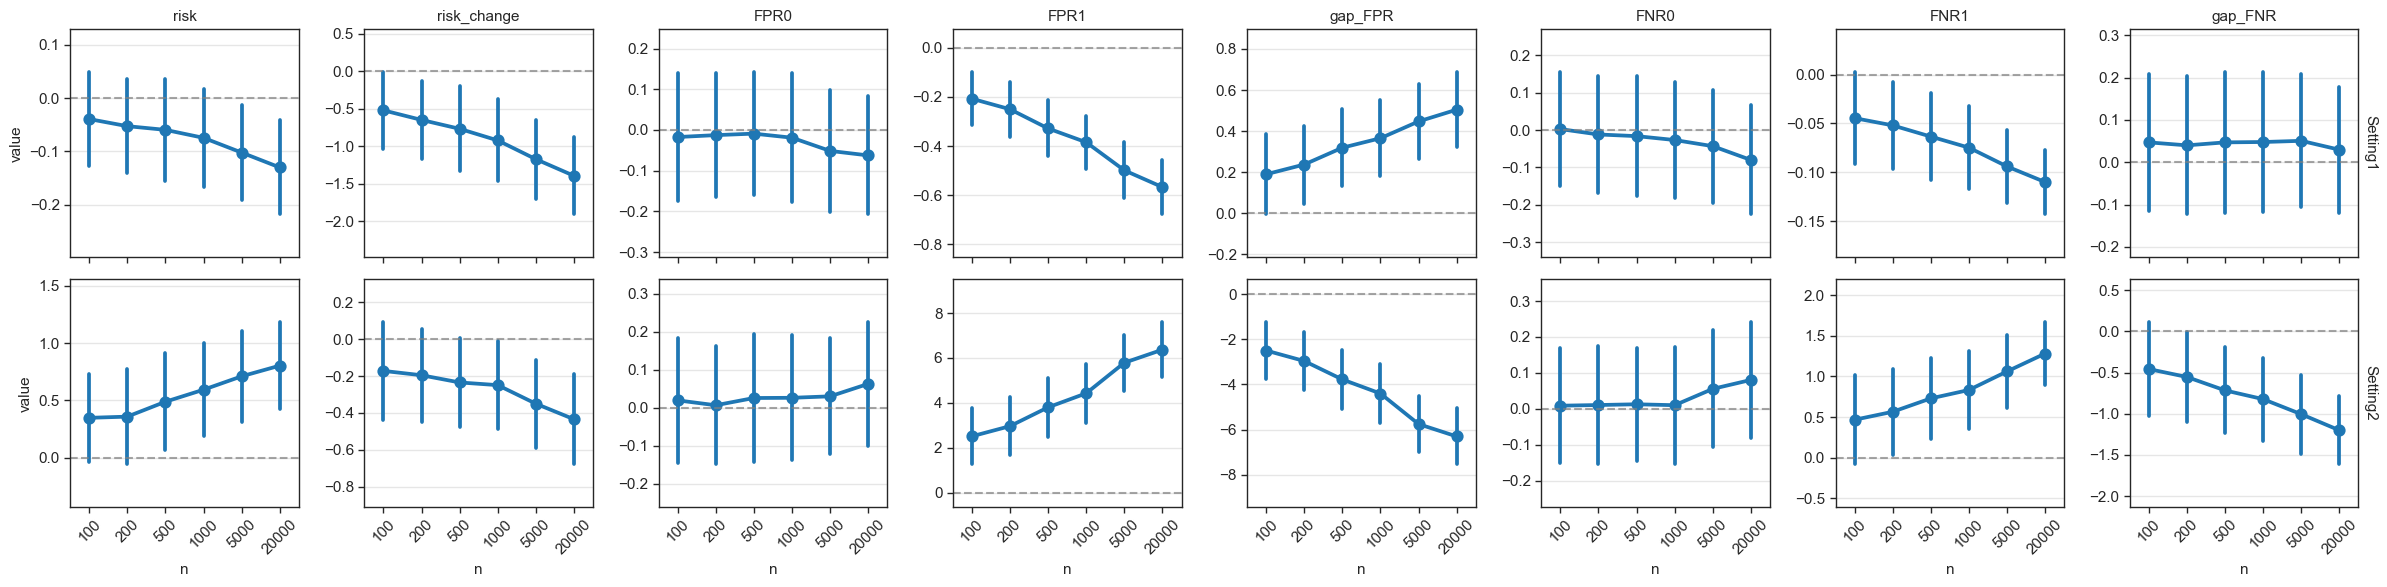

In [552]:
metrics_est_comb_pi_50 = transform_metrics(metrics_est_comb_pi, reference_col='true_value', scale=0.50)
plot_metrics(metrics_est_comb_pi_50, row='setting', col='metric', centered=True)

### Scaled by $n^{0.75}$

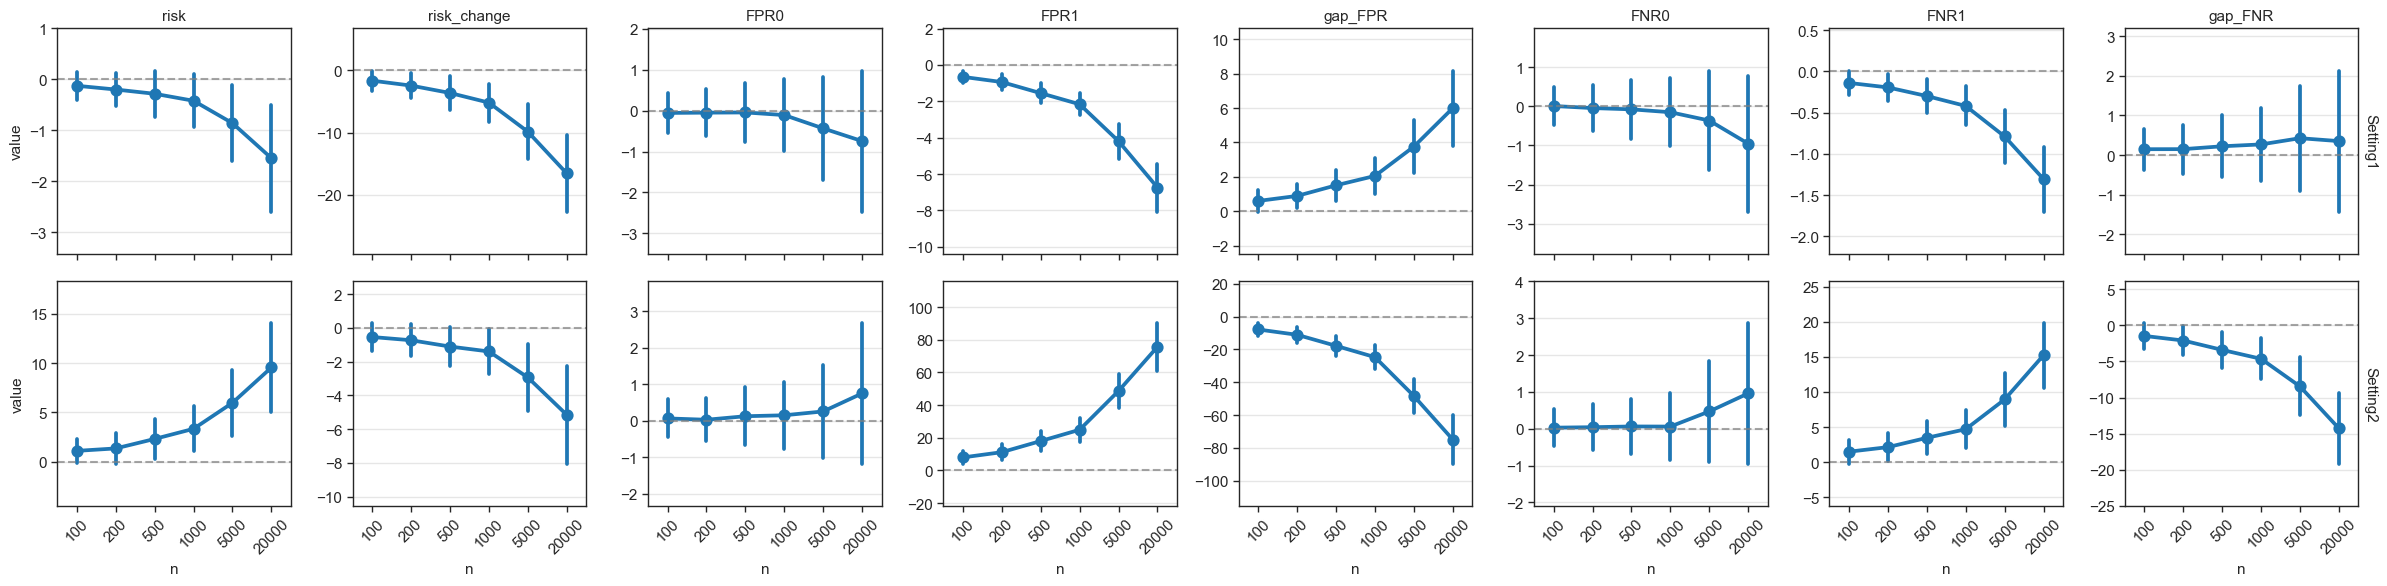

In [553]:
metrics_est_comb_pi_75 = transform_metrics(metrics_est_comb_pi, reference_col='true_value', scale=0.75)
plot_metrics(metrics_est_comb_pi_75, row='setting', col='metric', centered=True)

### Scaled by $n$

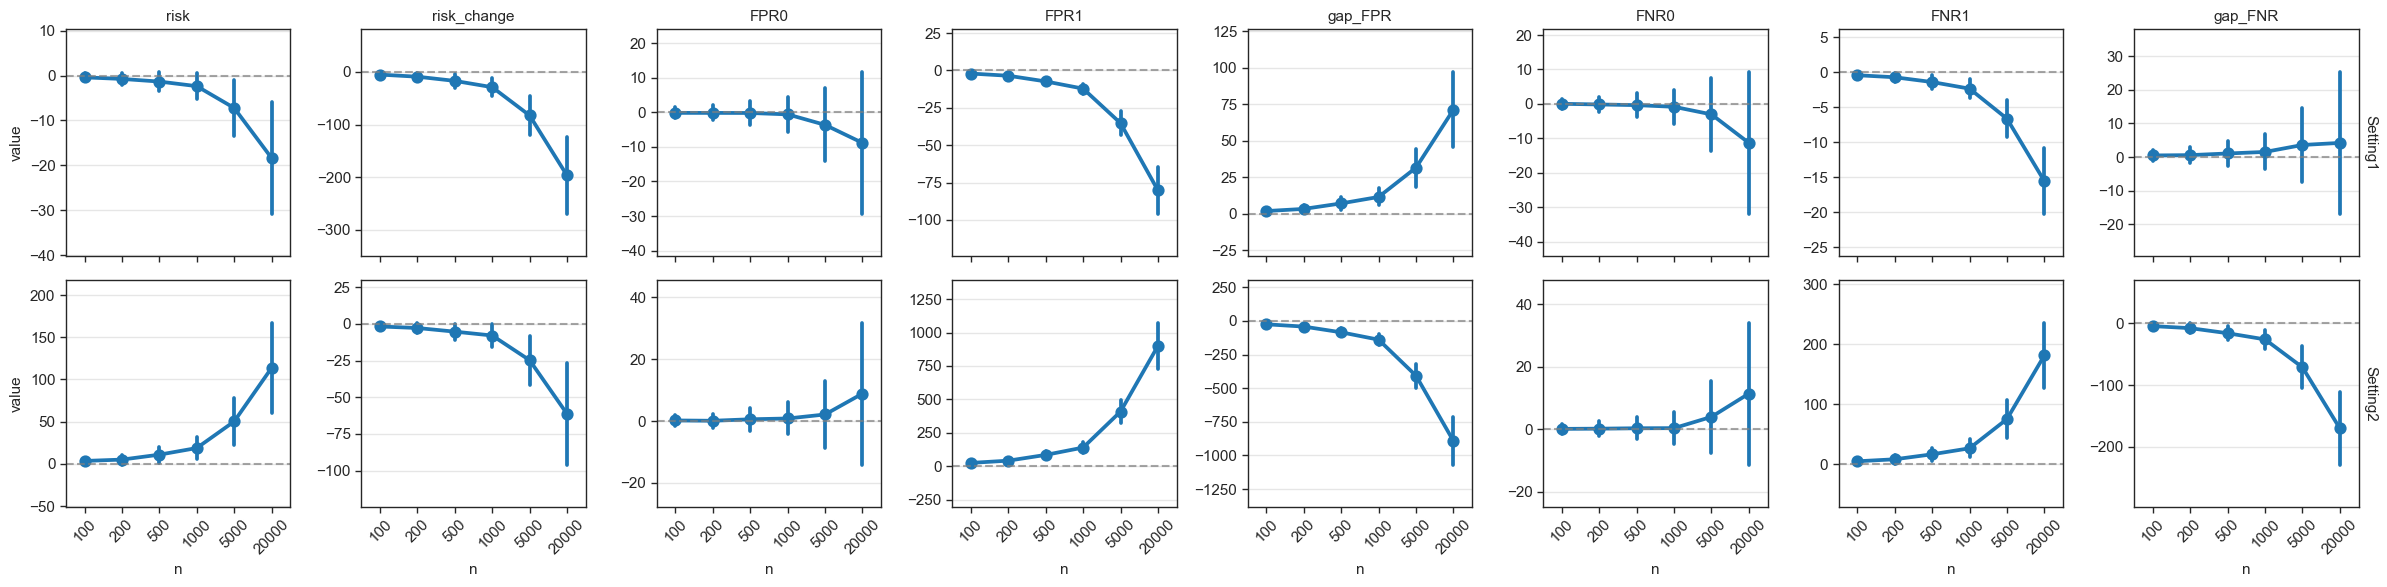

In [554]:
metrics_est_comb_pi_100 = transform_metrics(metrics_est_comb_pi, reference_col='true_value', scale=1.0)
plot_metrics(metrics_est_comb_pi_100, row='setting', col='metric', centered=True)

# Plots for paper
- Only the explanatory plot (Figure 1) and the plot of performance-fairness tradeoffs (Figure 3) are generated here. 
- The other plots for the paper were generated in R using `ggplot`, from the results above.

## Explanatory Figure for Intro

In [242]:
def intro_data_pre(n, pA, need_A, strength, prob_treated):
    """Generate data."""
    A = np.random.binomial(1, p = pA, size = n)
    Y0 = np.random.binomial(1, p = A*need_A[0] + (1 - A)*need_A[1], size = n)
    Y1 = np.copy(Y0)
    Y1[Y0 == 1] = np.random.binomial(1, 1 - strength, size = np.sum(Y0))
    AY0 = pd.DataFrame({'A': A, 'Y0': Y0})
    D_probs = (1-A)*(1-Y0)*prob_treated[0] + (1-A)*Y0*prob_treated[1] +\
              A*(1-Y0)*prob_treated[2] + A*Y0*prob_treated[3]
    D = np.random.binomial(1, D_probs)
    Y = D*Y1 + (1 - D)*Y0
    out = np.concatenate([A.reshape((n,1)), Y0.reshape((n,1)),
                          Y1.reshape((n,1)), D.reshape((n,1)), 
                          Y.reshape((n,1))], axis = 1)
    out = pd.DataFrame(out, columns = ['A', 'Y0', 'Y1', 'D', 'Y'])
    
    return out

In [243]:
def intro_data_post(n, pA, need_A, strength, prob_treated_pre, pred_rates):
    out = intro_data_pre(n, pA, need_A, strength, prob_treated_pre)
    D_new_probs = pred_rates[(0, 0, 'FPR')]*(1 - out.Y)*(1 - out.A) +\
                  pred_rates[(0, 1, 'TPR')]*out.Y*(1 - out.A) +\
                  pred_rates[(1, 0, 'FPR')]*(1 - out.Y)*out.A +\
                  pred_rates[(1, 1, 'TPR')]*out.Y*out.A
    D = np.random.binomial(1, D_new_probs)
    Y = D*out.Y1 + (1 - D)*out.Y0
    out['D'] = D
    out['Y'] = Y
    
    return out

In [244]:
def calc_errors(dat, pred_rates):
    """Compute P(S = 1|Y(0) = 1, A) for different predictors S.
    
    Args:
      pred_rates: P(S = 1|A, Y), a Series with index (A, Y). 
    """
    reg_Y = dat.loc[dat.Y0 == 1].groupby('A')['Y'].mean()
    cTPR0 = pred_rates[(0, 1, 'TPR')]*reg_Y[0] + pred_rates[(0, 0, 'FPR')]*(1 - reg_Y[0])
    cTPR1 = pred_rates[(1, 1, 'TPR')]*reg_Y[1] + pred_rates[(1, 0, 'FPR')]*(1 - reg_Y[1])
    
    reg_Y = dat.loc[dat.Y0 == 0].groupby('A')['Y'].mean()
    cFPR0 = pred_rates[(0, 1, 'TPR')]*reg_Y[0] + pred_rates[(0, 0, 'FPR')]*(1 - reg_Y[0])
    cFPR1 = pred_rates[(1, 1, 'TPR')]*reg_Y[1] + pred_rates[(1, 0, 'FPR')]*(1 - reg_Y[1])
    
    out = pd.DataFrame({'A': [0, 1], 'cTPR': [cTPR0, cTPR1], 'cFPR': [cFPR0, cFPR1]})
    return out

In [245]:
def calc_success(dat):
    """Compute P(Y = 0|A), the probability of success for groups A."""
    out = (1 - dat.groupby('A')['Y'].mean()).to_frame()
    return out

In [ ]:
n = 50000
pA = 0.7
need_A = [0.4, 0.2]

index = pd.MultiIndex.from_tuples([(0, 0, 'FPR'), (0, 1, 'TPR'), 
                                   (1, 0, 'FPR'), (1, 1, 'TPR')],
                                  names=['A', 'Y', 'type'])

prob_treated = [0.3, 0.6, 0.2, 0.4]
rates_unconstrained = pd.Series([0.2, 0.5, 0.6, 0.7], index = index)
rates_EO = pd.Series([0.1, 0.8, 0.1, 0.8], index = index)
opportunity_rates = np.array(prob_treated)[[1, 3]]

In [247]:
strength = np.linspace(0, 1, 21)
res_obs = [None]*len(strength)
res_EO_pre = [None]*len(strength)
res_EO_post = [None]*len(strength)

for i, s in enumerate(strength):
    dat_pre = intro_data_pre(50000, pA, need_A, s, prob_treated)
    dat_post = intro_data_post(50000, pA, need_A, s, prob_treated, rates_EO)
    res_EO_pre[i] = calc_errors(dat_pre, rates_EO)
    res_obs[i] = calc_success(dat_pre)
    res_EO_post[i] = calc_success(dat_post)

res_obs = pd.concat(res_obs, axis = 0, keys = strength)
res_obs = res_obs.reset_index().rename(columns = {'level_0': 'strength'})
res_EO_pre = pd.concat(res_EO_pre, axis = 0, keys = strength)
res_EO_pre = res_EO_pre.reset_index().rename(columns = {'level_0': 'strength'}).drop(columns = 'level_1')
res_EO_post = pd.concat(res_EO_post, axis = 0, keys = strength)
res_EO_post = res_EO_post.reset_index().rename(columns = {'level_0': 'strength'})

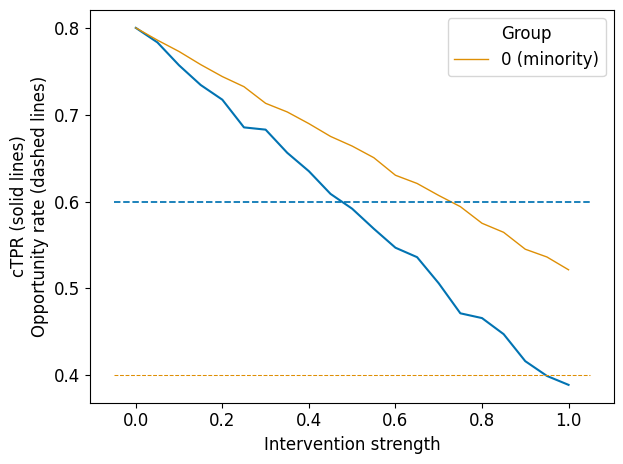

In [254]:
# from matplotlib import rcParams
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['pdf.fonttype'] = 42
ax = sns.lineplot(data=res_EO_pre, x='strength', y='cTPR', hue = 'A', size = 'A', sizes = [1.5, 1],
                 palette = sns.color_palette('colorblind')[0:2])
# ax.set_ylim(0, 1)
ax.set_xlabel('Intervention strength')
ax.set_ylabel('cTPR (solid lines)\nOpportunity rate (dashed lines)')
handles, labels = ax.get_legend_handles_labels()
ax.hlines(opportunity_rates, *ax.get_xlim(), color = sns.color_palette('colorblind')[0:2],
         linestyle = '--', linewidth=[1.25, 0.75])
# ax.legend(handles=handles[1:], labels=labels[1:], title = 'Group')
ax.legend(handles=handles[1:], labels=['0 (minority)', '1 (majority)'], title = 'Group')
plt.tight_layout()
plt.show()
ax.get_figure().savefig(os.path.join(FIGPATH, 'intro_figure.pdf'), pad_inches = 0)

## Task (3) plots: Simulating Performance tradeoffs

The goal here is to visualize the tradeoff between performance and accuracy. We start with a perfect predictor of $Y_0$ (not of $Y$) and get the optimal derived predictor over a grid of values for $(\epsilon^+, \epsilon^-)$.

The data generating process used in the other simulations results in a Bayes-optimal predictor with error rate differences around 0.05, so there's not much room to show tradeoffs. Hence we define a new data generating process just for this section.

In [ ]:
## Different beta_Y0 than what was used for the previous simulations.

prob_A = 0.3
beta_X = [1, -0.8, 4, 2]
beta_D_pre = [0.2, -1, 1, -1, 1]
beta_Y0 = [-4, 2/5.0, -3/5.0, 4/5.0, -1]
beta_Y1 = [1, -2, 3, -4, 5]

A = 'A'
X = ['X1', 'X2', 'X3', 'X4']
R = 'R'
D = 'D'
Y = 'Y'

data_params_pre = {
    'prob_A': prob_A,
    'beta_X': beta_X,
    'beta_D': beta_D_pre,
    'beta_Y0': beta_Y0,
    'beta_Y1': beta_Y1,
}

### Check that the data-generating process looks reasonable

In [50]:
dat = generate_data_pre(50_000, **data_params_pre)
dat['R'] = (dat.mu0 >= 0.5).astype(float)
check_data_post(dat)

Cross-tabs for sensitive feature A, decision D, potential outcome Y0, and observable outcome Y.
---------------
D      0.0    1.0
A                
0.0  17618  17493
1.0  12257   2632
---------------
Y0     0.0    1.0
A                
0.0  17553  17558
1.0  11972   2917
---------------
Y      0.0    1.0
A                
0.0  13015  22096
1.0  11470   3419
---------------

How often Y = Y0: 0.72824 

Properties of input predictor R

-------------------------
Confusion matrix for Y, R
-------------------------
[[0.31384 0.17586]
 [0.30466 0.20564]] 

------------------------------
Classification report for Y, R
------------------------------
              precision    recall  f1-score   support

       Y = 0       0.51      0.64      0.57     24485
       Y = 1       0.54      0.40      0.46     25515

    accuracy                           0.52     50000
   macro avg       0.52      0.52      0.51     50000
weighted avg       0.52      0.52      0.51     50000
 

---------------------

In [51]:
# Performance for the Bayes-optimal binary predictor of Y0 in A, X
metrics_post_simple([0, 1, 0, 1], dat, outcome='mu0', ci=None)

,metric,value,ci_lower,ci_upper
0,risk,0.239647,None,None
1,risk_change,0.000000,None,None
0,FPR0,0.273198,None,None
1,FPR1,0.040556,None,None
2,gap_FPR,0.232643,None,None
0,FNR0,0.266569,None,None
1,FNR1,0.691034,None,None
2,gap_FNR,-0.424465,None,None


In [52]:
## Get optimal derived predictor for each combo of unfairness tolerances

epsilons = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1] +\
       [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

res = simulate_performance_tradeoff(100_000, data_params_pre, epsilons, epsilons)
res.to_csv(os.path.join(OUTPATH, 'task3/optimal_predictors_grid.csv'), index = False)

### Generate plot

In [ ]:
res_array = res[res.metric == 'risk_change'].pivot(index='epsilon_neg',
                                                   columns='epsilon_pos',
                                                   values='value')
res_array = res_array.reindex(sorted(res_array.columns, reverse = True), axis = 1)

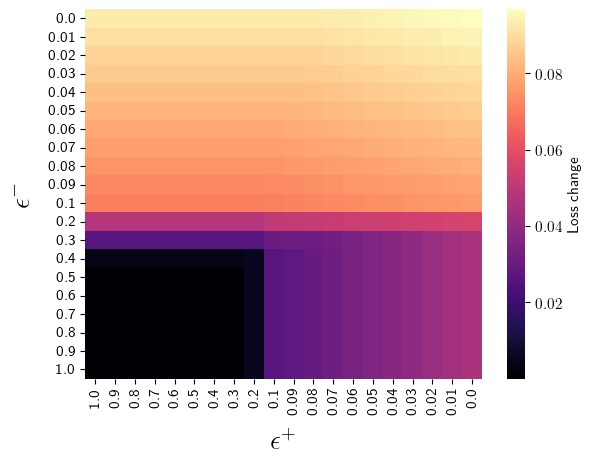

In [54]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = 11
ax = sns.heatmap(res_array, cmap = 'magma', cbar_kws = {'label': 'Loss change'})
ax.set_xlabel(r'$\epsilon^+$', fontsize = 20, labelpad = 10)
ax.set_ylabel(r'$\epsilon^-$', fontsize = 20, labelpad = 10)
ax.get_figure().savefig(os.path.join(OUTPATH, 'performance_tradeoff.png'),
                        bbox_inches = 'tight', dpi = 600)
plt.show()